In [1]:
using Pkg;
ENV["PYTHON"] = "";
Pkg.build("PyCall");
Pkg.add(PackageSpec(url="https://github.com/fkguo/IMinuit.jl"));

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/6e47d11ea2776bc5627421d59cdcc1296c058071/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/1fc929f47d7c151c839c5fc1375929766fb8edcc/build.log`
    Updating git-repo `https://github.com/fkguo/IMinuit.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Nutstore Files/Nutstore/codes/github/IAMfit/Project.toml`
  No Changes to `~/Nutstore Files/Nutstore/codes/github/IAMfit/Manifest.toml`


In [11]:
using CSV, DataFrames; ENV["COLUMNS"]=160 # for displaying more columns of a dataframe
using StaticArrays
using BenchmarkTools
using Plots, LaTeXStrings; using Plots.PlotMeasures; 
default(framestyle = :box, minorticks = 5, fg_color_legend = :lightgray);
using QuadGK; using Interpolations
using IMinuit

In [2]:
const unit = 1.0;
const fpi = 92.21unit; const mpic = 139.57018unit; const mpi0 = 134.9766unit;
const meta = 547.862unit; const mkc = 493.677unit; const mk0 = 497.614unit;
const mpi = (2mpic + mpi0)/3; const mk = (mkc + mk0)/2
const μ = 770.0unit;
const ϵ = eps();

# best fit parameters from Gomez Nicola, Pelaez
const lecr0 = [0.56e-3, 1.21e-3, -2.79e-3, -0.36e-3, 1.4e-3, 0.07e-3, -0.44e-3, 0.78e-3];

# NLO CHPT LECs
const lec_chpt = (0.4e-3, 1.35e-3, -3.5e-3, -0.3e-3, 1.4e-3, -0.2e-3, -0.4e-3, 0.9e-3)

const paras0 = [lecr0..., 1e-4];

# Data

The data for the 00 wave up to 970 MeV are taken from the table in the appendix of the GKPRY paper:

*The Pion-pion scattering amplitude. IV: Improved analysis with once subtracted Roy-like equations up to 1100 MeV*
 R. Garcia-Martin, R. Kaminski, J.R. Pelaez, J. Ruiz de Elvira, F.J. Yndurain, [Phys.Rev.D 83 (2011) 074004](https://doi.org/10.1103/PhysRevD.83.074004) [[1102.2183 [hep-ph]](https://arxiv.org/abs/1102.2183)]
The data points on $\delta_0^0$ above 970 MeV and $\eta_0^0$ taken read off from Figs. 15 and 17, respectively:

<img src="./datajl/pipi00_Roy-GKPY_PRD83_074004.png" style="height: 250px;"/>  <img src="./datajl/eta00_Roy-GKPY_PRD83_074004.png" style="height: 250px;"/> 

I tried to take data for the 11 and 20 waves above 970 MeV from:
*The Pion-pion scattering amplitude. III. Improving the analysis with forward dispersion relations and Roy equations*
R. Kaminski, J.R. Pelaez, F.J. Yndurain, [Phys.Rev.D 77 (2008) 054015](https://doi.org/10.1103/PhysRevD.77.054015) [[0710.1150 [hep-ph]](https://arxiv.org/abs/0710.1150)]

<img src="./datajl/pipi11_Roy-KPY_PRD77_054015.png" style="height: 250px;"/>  <img src="./datajl/pipi20_Roy-KPY_PRD77_054015.png" style="height: 250px;"/> 

However, the $\delta_0^2$ values do not match: the central value at 970 MeV in the figure is apperantly larger than that givein in the table. $\delta_1^1$ is roughly okay.

In [3]:
# data from the GKPRY paper
data_GKPRY_ππ00_df = DataFrame(CSV.File("./datajl/pipi/pipi00_Roy-GKPY_PRD83_074004.dat", header = [:w, :δ, :err], 
        delim=' ', ignorerepeated=true))
data_GKPRY_ππ11_df = DataFrame(CSV.File("./datajl/pipi/pipi11_Roy-GKPY_PRD83_074004.dat", header = [:w, :δ, :err], 
        delim=' ', ignorerepeated=true))
data_GKPRY_ππ20_df = DataFrame(CSV.File("./datajl/pipi/pipi20_Roy-GKPY_PRD83_074004.dat", header = [:w, :δ, :err], 
        delim=' ', ignorerepeated=true))
data_GKPRY_ππ00_eta_df = DataFrame(CSV.File("./datajl/pipikk/eta00_Roy-GKPY_PRD83_074004.dat", header = [:w, :η, :err], 
        delim=' ', ignorerepeated=true));
# join(data_GKPRY_ππ00_df, data_GKPRY_ππ11_df, data_GKPRY_ππ20_df, on = :w, makeunique=true)

In [4]:
# Cohen et al., PRD22,2595 (1980)
data_ππkk00_Cohen_df = DataFrame(CSV.File("./datajl/pipikk/pipikk-Cohen-PRD22_2595.dat", header = [:w, :δ, :err], 
        delim='\t', ignorerepeated=true))
# Martin and Ozmutlu, NPB158,520 (1979); 9 points below 1.2 GeV
data_ππkk00_Martin_df = DataFrame(CSV.File("./datajl/pipikk/pipikk-Martin-NPB158_520.dat", header = [:w, :δ, :err],
        delim='\t', ignorerepeated=true));

# recommended inelasticity data by Jose. 
# from Kaminski, Leniak, Rybicki, Z.Phys.C 74 (1997) 79-91, https://inspirehep.net/literature/419770
# 30 points below 1.2 GeV
data_ππ00_eta_Kaminski_df = DataFrame(CSV.File("./datajl/pipikk/S0ine-Kaminski-ZPC74_79.dat", 
        header = [:w, :η, :err], delim='\t', ignorerepeated=true));

In [5]:
# Armstrong et al. [WA76], Z.Phys.C 52 (1991) 389-396
data_πη_WA76_df = DataFrame(CSV.File("./datajl/pieta_ZPC52_389.csv", header = [:w, :y, :err]));
# interpolate the background extracted from data
data_πη_WA76_bg_df = sort(DataFrame(CSV.File("./datajl/pieta_bg_ZPC52_389.csv", header = [:w, :y])), :w)
const data_πη_WA76_bg = LinearInterpolation(data_πη_WA76_bg_df.w, data_πη_WA76_bg_df.y);

In [6]:
# S-wave Kπ scattering phase shifts
# Aston et al, NPB296, 493; 21 points below 1.2 GeV
data_πK10_Aston_df = DataFrame(CSV.File("./datajl/kpi/S-Aston-PhaseShift-New.dat", 
        header = [:w, :δ, :err], delim="\t", ignorerepeated=true))
# Estabrooks et al., NPB133, 490; 19 points below 1.2 GeV
data_πK10_Estabrooks_df = DataFrame(CSV.File("./datajl/kpi/S-Estabrooks-PhaseShift-New.dat", 
        header = [:w, :δ, :err], delim='\t', ignorerepeated=true));
# Mercer et al., NPB32, 381; 14 points below 1.2 GeV
data_πK10_Mercer_df = DataFrame(CSV.File("./datajl/kpi/S-Mercer-PhaseShift-NPB32_381.dat", 
        header = [:w, :δ, :err]))
# Bingham et al., NPB296, 493; 19 points below 1.2 GeV
data_πK10_Bingham_df = DataFrame(CSV.File("./datajl/kpi/S-Bingham-PhaseShift-NPB296_493.dat", 
        header = [:w, :δ, :err]))
# Baker et al., NPB99, 211
data_πK10_Baker_df = DataFrame(CSV.File("./datajl/kpi/S-Baker-PhaseShift-NPB99_211.dat", 
        header = [:w, :δ, :err], delim=" ", ignorerepeated=true))
# BaBar, PRD83, 072001
data_πK10_BaBar_df = DataFrame(CSV.File("./datajl/kpi/S-BaBar-PhaseShift_PRD83_072001.dat", 
        header = [:w, :δ, :err], delim="\t", ignorerepeated=true))
# BES, PRD94, 032001
data_πK10_BES_df = DataFrame(CSV.File("./datajl/kpi/S-BES-PhaseShift_PRD94_032001.dat", 
        header = [:w, :δ, :err], delim=" ", ignorerepeated=true))

# 21 points below 1.2 GeV
data_πK11_Aston_df = DataFrame(CSV.File("./datajl/kpi/P-Aston-NPB296_493.dat", 
        header = [:w, :δ, :err], delim=' ', ignorerepeated=true))
# 23 points up to 1.2 GeV
data_πK11_Estabrooks_df = DataFrame(CSV.File("./datajl/kpi/P-Estabrooks-NPB133_490.dat", 
        header = [:w, :δ, :err], delim=' ', ignorerepeated=true))
# 14 points below 1.2 GeV
data_πK11_Mercer_df = DataFrame(CSV.File("./datajl/kpi/P-Mercer_PhaseShift_NPB32_381.dat", 
        header = [:w, :δ, :err], delim='\t', ignorerepeated=true))

# 10 data points below 1.2 GeV
data_πK30_Estabrooks_df = DataFrame(CSV.File("./datajl/kpi/S32-Estabrooks-NPB133_490.dat", 
        header = [:w, :δ, :err], delim=' ', ignorerepeated=true))
data_πK30_Lingin_df = DataFrame(CSV.File("./datajl/kpi/S32-Linglin_NPB57_64.dat", 
        header = [:w, :δ, :err], delim='\t', ignorerepeated=true))
# 14 points below 1.2 GeV
data_πK30_Mercer_df = DataFrame(CSV.File("./datajl/kpi/S32-Mercer-PhaseShift-NPB32_381.dat", 
        header = [:w, :δ, :err], delim='\t', ignorerepeated=true));

In [7]:
data_πK10_combined_df = sort(vcat(data_πK10_Aston_df, data_πK10_Estabrooks_df, data_πK10_Mercer_df, data_πK10_Bingham_df, data_πK10_Baker_df,
        data_πK10_BaBar_df, data_πK10_BES_df), :w);
data_πK11_combined_df = sort(vcat(data_πK11_Aston_df, data_πK11_Estabrooks_df, data_πK11_Mercer_df), :w);
data_πK30_combined_df = sort(vcat(data_πK30_Estabrooks_df, data_πK30_Lingin_df, data_πK30_Mercer_df), :w);

data_ππKK_combined_df = sort(vcat(data_ππkk00_Cohen_df, data_ππkk00_Martin_df), :w);

In [8]:
const data_ππ00 = Data(data_GKPRY_ππ00_df)
const data_ππ11 = Data(data_GKPRY_ππ11_df)
const data_ππ20 = Data(data_GKPRY_ππ20_df)
const data_ππ00_eta = Data(data_ππ00_eta_Kaminski_df[1:30,:]);
const data_ππKK00 = Data(data_ππKK_combined_df[ data_ππKK_combined_df.:w .<=1200, :]);
const data_πK10 = Data(data_πK10_combined_df[ data_πK10_combined_df.:w .<=1200, :])
const data_πK11 = Data(data_πK11_combined_df[ data_πK11_combined_df.:w .<=1200, :])
const data_πK30 = Data(data_πK30_combined_df[ data_πK30_combined_df.:w .<=1200, :])
const data_πη = Data(data_πη_WA76_df);

┌ Warning: backend `PyPlot` is not installed.
└ @ Plots ~/.julia/packages/Plots/modjX/src/backends.jl:43


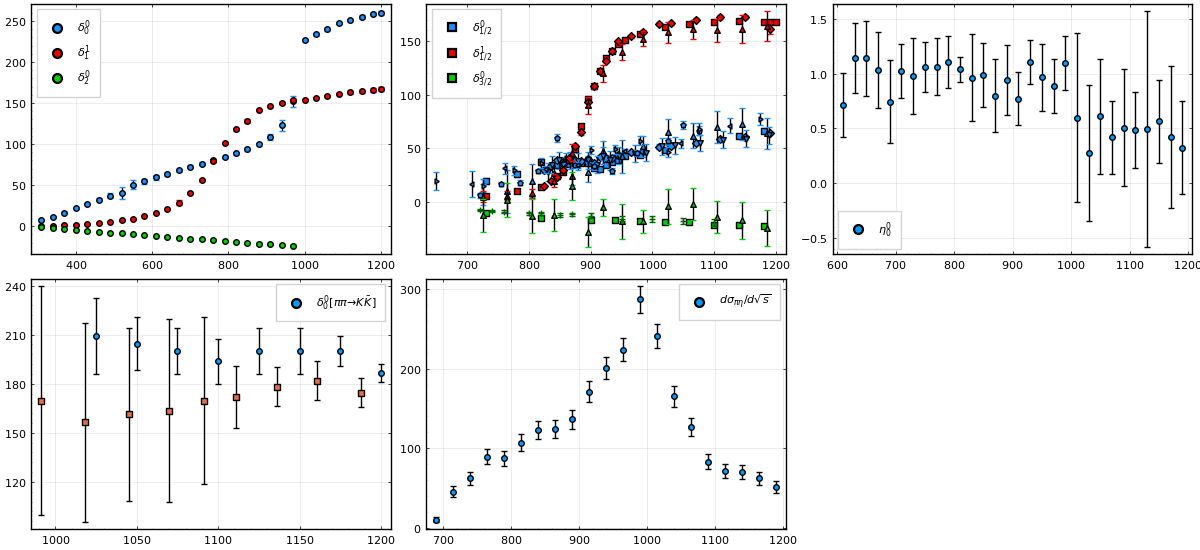

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [14]:
pyplot()
let p1, p2, p3, p4
    p1 = @plt_data data_ππ00 label = L"\delta_{0}^0" marker = (:circle, :dodgerblue) legend=:topleft
    @plt_data! data_ππ11 label = L"\delta_{1}^1" marker = (:circle, :red2)
    @plt_data! data_ππ20 label = L"\delta_{2}^0" marker = (:circle, :green3)
    
    p2 = @plt_data Data(data_πK10_Estabrooks_df)[1:19] label = L"\delta_{1/2}^0" marker = (:rect, :dodgerblue) legend=:topleft
    @plt_data! Data(data_πK10_Aston_df)[1:21] label = "" marker = (:diamond, :dodgerblue)
    @plt_data! Data(data_πK10_Mercer_df)[1:14] label = "" marker = (:utriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Bingham_df)[1:19] label = "" marker = (:dtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Baker_df) label = "" marker = (:pentagon, :dodgerblue)
    @plt_data! Data(data_πK10_BES_df) label = "" marker = (:rtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_BaBar_df) label = "" marker = (:ltriangle, :dodgerblue)
    
    @plt_data! Data(data_πK11_Estabrooks_df)[1:23] label = L"\delta_{1/2}^1" marker = (:rect, :red2)
    @plt_data! Data(data_πK11_Aston_df)[1:21] label = "" marker = (:diamond, :red2)
    @plt_data! Data(data_πK11_Mercer_df)[1:14] label = "" marker = (:utriangle, :red2)
 
    @plt_data! Data(data_πK30_Estabrooks_df)[1:10] label = L"\delta_{3/2}^0" marker = (:rect, :green3)
    @plt_data! Data(data_πK30_Mercer_df)[1:14] label="" marker = (:utriangle, :green3)
    @plt_data! Data(data_πK30_Lingin_df) label="" marker = (:+, :darkgreen ) #, stroke(:darkgreen))

    p3 = @plt_data data_ππ00_eta label = L"\eta_{0}^0" legend=:bottomleft
    p4 = @plt_data Data(data_ππkk00_Cohen_df) label = L"\delta_{0}^0 [\pi\pi\to K \bar K]"
    @plt_data! Data(data_ππkk00_Martin_df)[1:9] label = "" marker = :rect
    
    p5 = @plt_data data_πη label = L"d\sigma_{\pi\eta}/d\sqrt{s}"
    
    plot(p1, p2, p3, p4, p5, size=(1200,550))
end

# UCHPT

In [15]:
struct TwoBodyChannel{T<:AbstractFloat} 
    m1::T
    m2::T
end

qon(s, m1, m2) = sqrt((s - (m1+m2)^2) * (s - (m1-m2)^2))/(2sqrt(s))

qon (generic function with 1 method)

In [16]:
const ππ = TwoBodyChannel(mpi, mpi)
const KK = TwoBodyChannel(mk, mk)
const ηη = TwoBodyChannel(meta, meta)
const πη = TwoBodyChannel(mpi, meta)
const Kπ = TwoBodyChannel(mk, mpi)
const Kη = TwoBodyChannel(mk, meta);

In [17]:
# load some const definitions used in tmatrix.jl
include("src/init_const.jl");

In [18]:
# amplitudes from LO and NLO CHPT
include("src/amplitudes.jl")
# amplitudes from IAM
include("src/tmatrix.jl")
# modifications to satisfy unitarity
include("src/unitarity_modification.jl")
include("src/phaseshifts.jl");

In [19]:
const cmatrix22 = zeros(ComplexF64, 2, 2);
const cmatrix33 = zeros(ComplexF64, 3, 3);

In [20]:
# checked with FORTRAN; 0 allocations with julia >=1.5.0
@time St4_11!(cmatrix22, 1040, lecr0) 

  0.000191 seconds


2×2 SMatrix{2, 2, ComplexF64, 4} with indices SOneTo(2)×SOneTo(2):
 33.9427+7.56418im  6.91715+1.67792im
 6.91715+1.67792im  1.17247+0.372205im

In [17]:
# checked with FORTRAN; 0 allocations with julia >=1.5.0
@btime St4_00!(cmatrix33, 540, lecr0) samples=100

  388.098 μs (0 allocations: 0 bytes)


3×3 SMatrix{3, 3, ComplexF64, 9} with indices SOneTo(3)×SOneTo(3):
 19.5196+18.817im     5.2616+8.4232im    1.91678-0.366946im
  5.2616+8.4232im    36.0172+3.77055im   -12.335-0.164259im
 1.91678-0.366946im  -12.335-0.164259im  14.1191+0.00715573im

In [18]:
# IJ = 11, ππ, KK; checked with FORTRAN
@btime Stiam_11(540, lecr0) samples=100

  201.869 μs (0 allocations: 0 bytes)


2×2 SMatrix{2, 2, ComplexF64, 4} with indices SOneTo(2)×SOneTo(2):
  8.63521+1.304im    -1.65164+10.9373im
 -1.65164+10.9373im  -13.8532-2.09197im

In [19]:
# IJ = 00, ππ, KK, ηη; checked with FORTRAN
@time Stiam_00(540, lecr0) 

  0.000388 seconds


3×3 SMatrix{3, 3, ComplexF64, 9} with indices SOneTo(3)×SOneTo(3):
  28.1853+37.0394im    16.0719+21.1208im   -0.37278-0.489886im
  16.0719+21.1208im   -13.3513+12.0436im    7.68306-0.279345im
 -0.37278-0.489886im   7.68306-0.279345im   35.0499+0.00647928im

In [20]:
@time Stiam_10(540, lecr0) 

  0.000185 seconds


2×2 SMatrix{2, 2, ComplexF64, 4} with indices SOneTo(2)×SOneTo(2):
 0.369504+2.74509e-18im  1.27844+7.96973e-18im
  1.27844+7.96973e-18im  4.28488+2.31424e-17im

Linear combinations of LECs:

| NLO amp. | LEC combinations from the NLO scattering amplitudes            |
|:---|:---|
|V4_I0_ππππ, V4_I1_ππππ  | $2L_1 + L_3$, $L_2$, $2L_4+L5$, $2L_6+L_8$ |
|V4_I0_ππkk, V4_I1_kπkπ, V4_I3_kπkπ | $L_1, L_2, L_3, L_4, L_5, 2L_6+L_8$ |
|V4_I0_kkkk, V4_I1_kkkk | $L_1, L_2, L_3, L_4, L_5, 2L_6+L_8$ |
|V4_I0_ππηη, V4_I1_πηπη  | $L_1, L_2, L_3, L_4, 2m_\eta^2 m_\pi^2(-L_5/3 + 2 L_6) + 4m_\pi^2 (- m_\eta^2 + m_\pi^2) L_7 + 2 m_\pi^4 L_8$ |
|V4_I0_kkηη | $L_1, L_2, L_3, L_4, L_5, 8m_\eta^2 m_K^2 (-L_4+L_6) + 2 (3 m_\eta^4 - 4 m_\eta^2 m_\pi^2 + m_\pi^4) L_7 + (6 m_\eta^4 - 3 m_\eta^2 m_\pi^2 + m_\pi^4) L_8$ |
|V4_I1_πηkk | $L_3, L_5, 6(m_\eta^4-m_\pi^4)(2L_7+ L_8)$|

In [21]:
# πη invariant mass distribution
function σπη(w, paras)
    _m1, _m2 = πη.m1, πη.m2
    _c = @views paras[9]
    if w ≥ _m1 + _m2 + 0.0000001
        _q = qon(w^2, _m1, _m2)
        _tm = Stiam_10(w, @views paras[1:8])[2, 1]
        res = _c * _q * abs2(_tm ) + data_πη_WA76_bg(w) # _bg* _q^4 )
    else
        res = 0.0
    end
    return  res 
end

σπη (generic function with 1 method)

In [22]:
function plt_compare(paras; jump = 900)
    _lec = Ref(paras[1:8])
    wv = 270:1.0:1200
    p1 = plot(wv, δ00.(wv, _lec; jump = jump), label="", xlim = (wv[1], wv[end]),legend=:topleft)
    plot!(wv, δ11.(wv, _lec), label="" )
    plot!(wv, δ20.(wv, _lec), label="" )
    @plt_data! data_ππ00 label = L"\delta_{0}^0" marker = (:circle, :dodgerblue)
    @plt_data! data_ππ11 label = L"\delta_{1}^1" marker = (:circle, :darkorange)
    @plt_data! data_ππ20 label = L"\delta_{2}^0" marker = (:circle, :green3) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{J}^I (\pi\pi\to \pi\pi)"
    hline!([0], color = :black, label=:none)    
    
    xv = 630:1.0:1200
    p2 = plot(xv, δhalf0.(xv, _lec), label="", xlim = (xv[1], xv[end]),legend=:topleft)
    plot!(xv, δhalf1.(xv, _lec), label="" )
    plot!(xv, δ3half0.(xv, _lec), label="" )
    @plt_data! Data(data_πK10_Estabrooks_df)[1:19] label = L"\delta_{1/2}^0" marker = (:rect, :dodgerblue)
    @plt_data! Data(data_πK10_Aston_df)[1:21] label = "" marker = (:diamond, :dodgerblue)
    @plt_data! Data(data_πK10_Mercer_df)[1:14] label = "" marker = (:utriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Bingham_df)[1:19] label = "" marker = (:dtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Baker_df) label = "" marker = (:pentagon, :dodgerblue)
    @plt_data! Data(data_πK10_BES_df) label = "" marker = (:rtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_BaBar_df) label = "" marker = (:ltriangle, :dodgerblue)
    
    @plt_data! Data(data_πK11_Estabrooks_df)[1:23] label = L"\delta_{1/2}^1" marker = (:rect, :darkorange)
    @plt_data! Data(data_πK11_Aston_df)[1:21] label = "" marker = (:diamond, :darkorange)
    @plt_data! Data(data_πK11_Mercer_df)[1:14] label = "" marker = (:utriangle, :darkorange)
 
    @plt_data! Data(data_πK30_Estabrooks_df)[1:10] label = L"\delta_{3/2}^0" marker = (:rect, :green3)
    @plt_data! Data(data_πK30_Mercer_df)[1:14] label="" marker = (:utriangle, :green3)
    @plt_data! Data(data_πK30_Lingin_df) label="" marker=(:circle, :darkgreen) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{J}^I (K\pi\to K \pi)"
    hline!([0], color = :black, label=:none)   
    
    wv2 = 985:1.0:1200
    p3 = plot(wv2, δππkk00.(wv2, _lec), label = "", xlim = (wv2[1], wv2[end]), ylim=(0,260) )
    @plt_data! Data(data_ππkk00_Cohen_df) label = "" marker = :darkorange
    @plt_data! Data(data_ππkk00_Martin_df)[1:9] label="" marker=(:rect,:darkorange) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{0}^0 (\pi\pi\to K \bar K)"
       
    p4 = plot(wv2, η00.(wv2, _lec), legend = :none, xlim = (wv2[1], wv2[end]), ylim=(0, 1.6))
    @plt_data! data_ππ00_eta marker = :darkorange xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\eta_{0}^0" # label = L"\eta_{0}^0"
    
    wv3 = (mpi+meta+0.000001):1.0:1075
    p5 = plot(wv3, σπη.(wv3, Ref(paras)), label = "", xlim = (wv3[1], wv3[end]) ,legend=:topleft)
    @plt_data! data_πη[1:16] label = "" 
    plot!(wv3, data_πη_WA76_bg.(wv3), line=(:dashdot, :gray), label="background" )
    plot!(xlab=L"\sqrt{s}"*" [MeV]", ylab = L"d\sigma_{\pi\eta}/d\sqrt{s}"*" [events/25 MeV]", ylim=(0, 320))
    
    plot(p1, p2, p3, p4, p5, size=(1200,550))
end

plt_compare (generic function with 1 method)

  4.013134 seconds (18.01 M allocations: 861.547 MiB, 3.38% gc time, 78.25% compilation time)


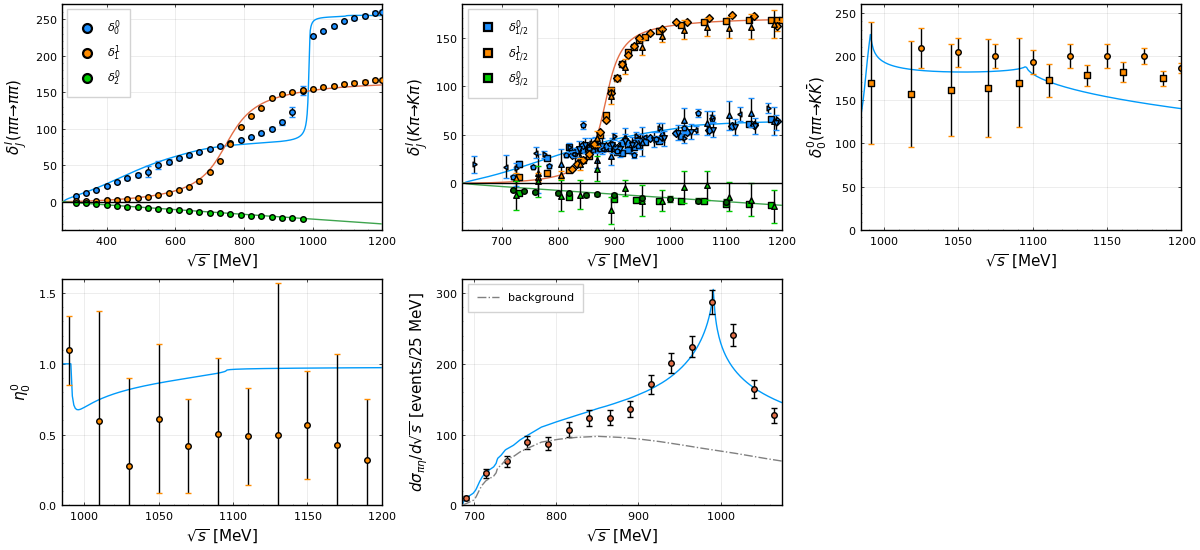

In [23]:
@time plt_compare([lecr0..., 1e-4]; jump = 900)

In [24]:
function plt_unitarity_test(tm, ch1, ch2; lec=lecr0, kwds...) 
#     ch1 = ππ; ch2 = KK;
    wv = (ch1.m1+ch1.m2):1:1100 #(ch2.m1+ch2.m2)
    tij(w) = tm(w, lec)  
    _im1(w) = imag(tij(w)[1,1])
    _re1(w) = real(tij(w)[1,1])
    _abs2(w) = abs2(tij(w)[1,1])
    _rho1(w) = qon(w^2, ch1.m1, ch1.m2)/(8π*w); _rho2(w) = qon(w^2, ch2.m1, ch2.m2)/(8π*w)
    _rhs(w) = (w <= ch2.m1+ch2.m2 ? _abs2(w) * _rho1(w) : 
        _abs2(w) * _rho1(w) + abs2(tij(w)[1,2])*_rho2(w))
    p1 = plot(wv, _im1.(wv); label = "Im "*L"T", kwds... )
    plot!(wv, _rhs.(wv); label = L"T\Sigma T^\dag", line = :dash )
    plot!(wv, _re1.(wv); label = "Re "*L"T", line = :dot )
end

# plotly()
function plt_unitarity(lec)
    p1 = plt_unitarity_test(Stiam_00, ππ, KK, lec=lec, ylab = L"T_0^0[\pi\pi\to \pi\pi]")
    p2 = plt_unitarity_test(Stiam_11, ππ, KK, lec=lec, xlab = L"\sqrt{s}"*" [MeV]", ylab = L"T_1^1[\pi\pi\to \pi\pi]")
    p3 = plt_unitarity_test(Stiam_10, πη, KK, lec=lec, xlab = L"\sqrt{s}"*" [MeV]", ylab = L"T_1^0[\pi\eta\to \pi\eta]")
    p4 = plt_unitarity_test(Stiam_strange_10, Kπ, Kη, lec=lec, ylab = L"T_0^{1/2}[K\pi\to K\pi]")
    p5 = plt_unitarity_test(Stiam_strange_11, Kπ, Kη, lec=lec, xlab = L"\sqrt{s}"*" [MeV]", ylab = L"T_1^{1/2}[K\pi\to K\pi]")
    plot(p1, p2, p3, p4, p5, layout = 5, size=(1200,500))
end

plt_unitarity (generic function with 1 method)

In [25]:
include("src/tmatrix.jl")

tiam_01 (generic function with 1 method)

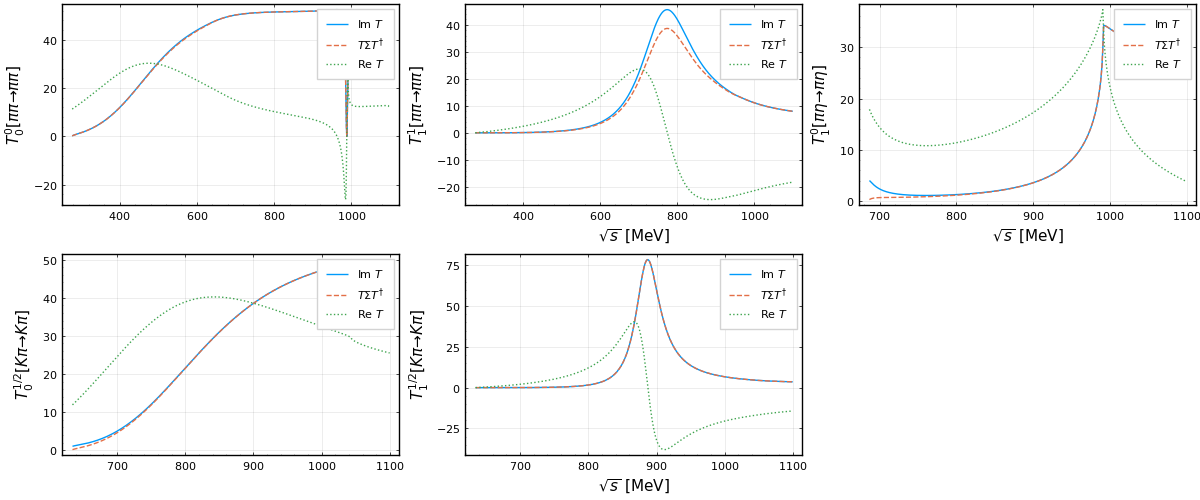

In [26]:
pyplot()# plotly() #to make numerical comparison visible, use plotly()
plt_unitarity(lecr0)

In [27]:
include("src/unitarity_modification.jl");

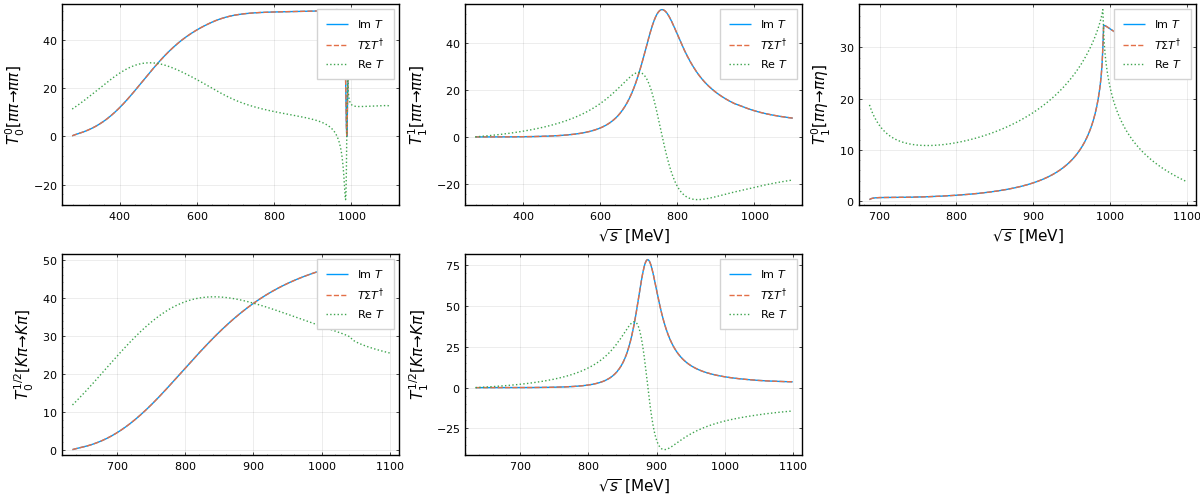

In [28]:
plt_unitarity(lecr0)
# savefig("unitarity_mod.pdf")

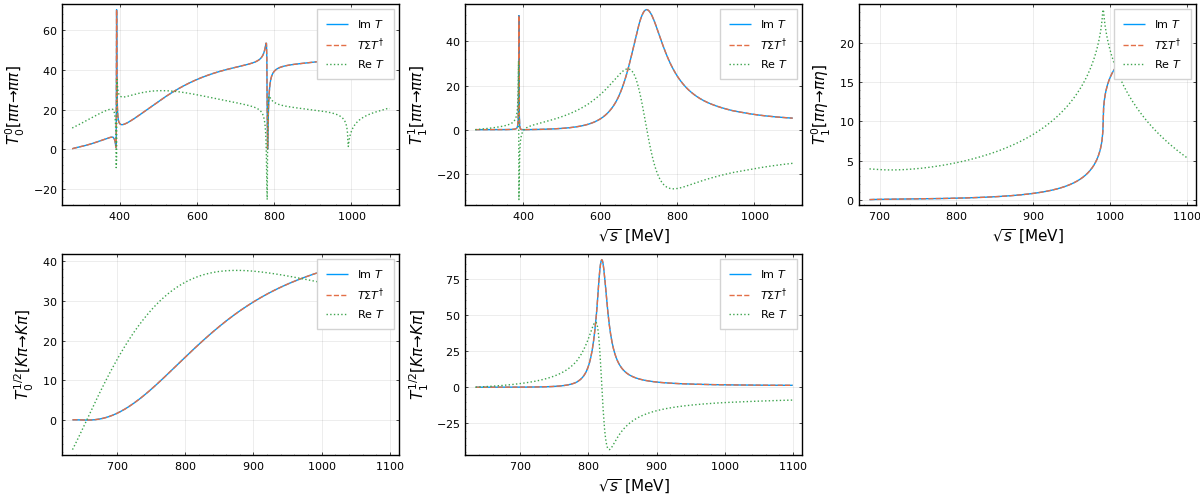

In [29]:
# pyplot()
plt_unitarity(lec_chpt)

In [30]:
function plt_iam(tiam, lec)
    wv = 200:2:1200
    n = length(tiam(300, lec)) 
    p = Vector{Any}(undef, n)
    for i = 1:n
        stm11(w) = tiam(w, lec)[i]
        p[i] = plot( wv, (@. abs(stm11(wv)) ), label="|T($i)|" )
        plot!( wv, (@. real(stm11(wv)) ), line = :dash, label="Re T($i)" )
        plot!( wv, (@. imag(stm11(wv)) ), line = :dot, label="Im T($i)" )
    end
    plot(p..., layout = n, size=(700,500)) #, legend=:outertopright)
end

plt_iam (generic function with 1 method)

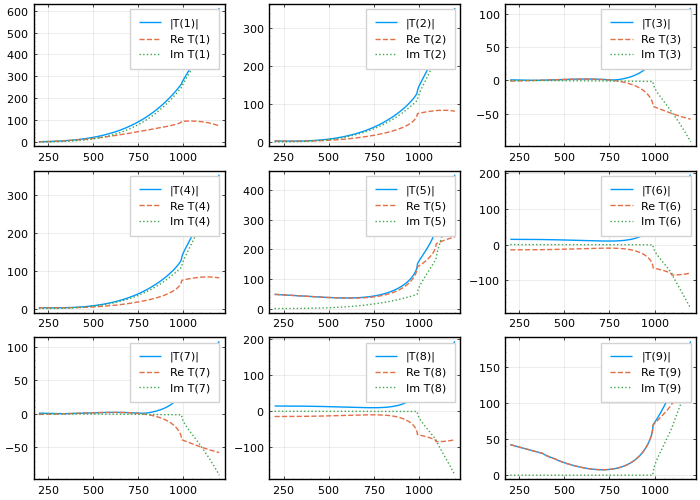

In [31]:
# NLO amplitudes
# @time 
plt_iam((w, lec)->St4_00!(cmatrix33, w, lec), lecr0)

  4.338897 seconds (38.03 k allocations: 2.598 MiB)


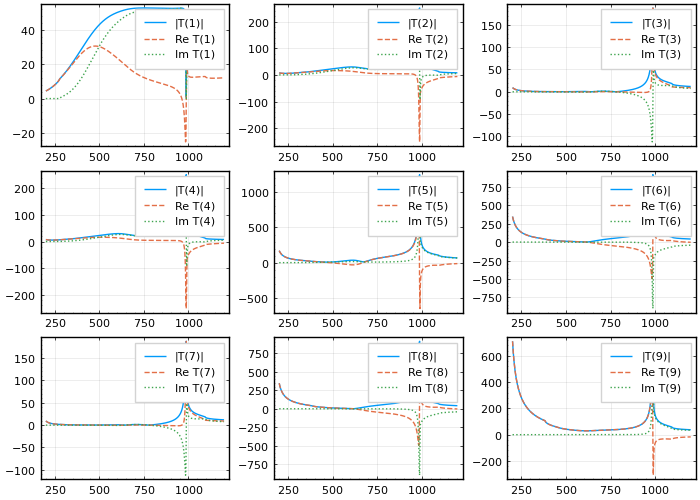

In [32]:
@time plt_iam(Stiam_00, lecr0)

  0.905390 seconds (78.38 k allocations: 4.692 MiB, 3.05% gc time, 7.14% compilation time)


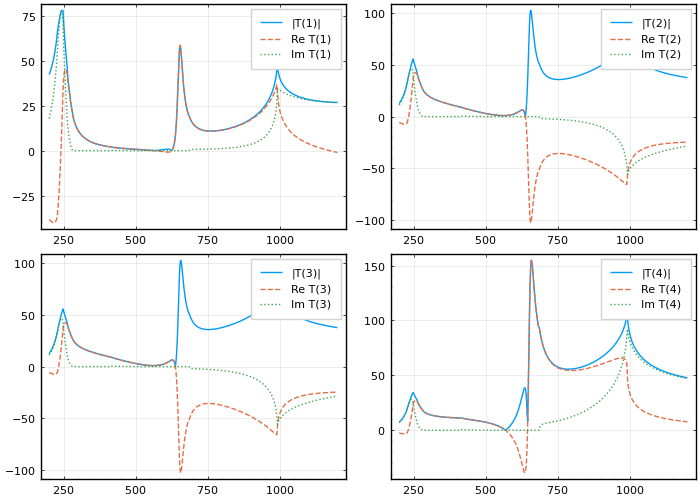

In [33]:
@time plt_iam(Stiam_10, lecr0)

  0.971174 seconds (16.98 k allocations: 1.160 MiB)


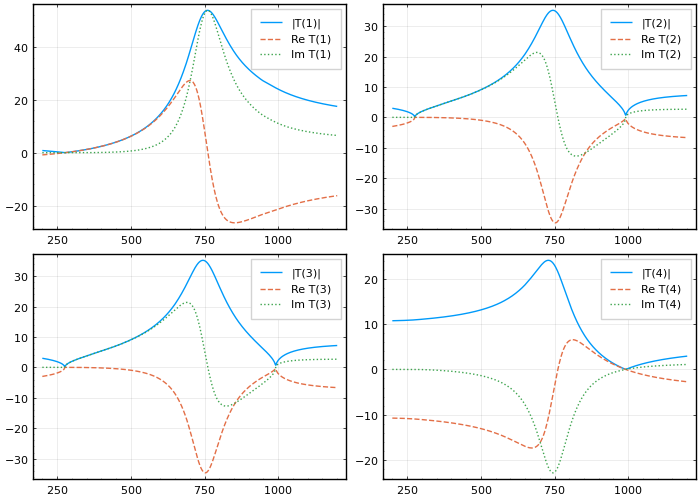

In [34]:
@time plt_iam(Stiam_11, lecr0)

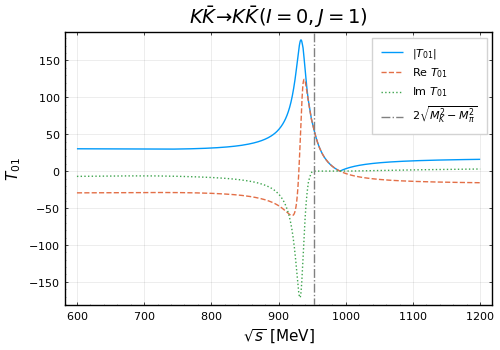

In [32]:
let wv = 600:0.5:1200, amp
    amp(w) = tiam_01(w, lecr0)
    plot( wv, (@. abs(amp(wv)) ), label=L"|T_{01}|", size=(500,350), xlab=L"\sqrt{s}"*" [MeV]", ylab=L"T_{01}")
    plot!( wv, (@. real(amp(wv)) ), line=:dash, label="Re "*L"T_{01}")
    plot!( wv, (@. imag(amp(wv)) ), line=:dot, label="Im "*L"T_{01}")
    vline!([sqrt(4mk^2-4mpi^2)], line=(:dashdot,:gray), label=L"2\sqrt{M_K^2-M_\pi^2}" )
    plot!(title=L"K\bar K\to K\bar K (I=0, J=1)")
    
end

# Fits

Following [Kaminski et al., Phys.Lett.B 551 (2003) 241-248](https://inspirehep.net/literature/600560), the chi-square for fitting to the phase shifts can be defined as
\begin{equation}
  \chi^2 = \sum_{i = 1}^N \left[ \frac{\sin\left(\delta_\ell^I(s_i) - \varphi_\ell^I(s_i) \right) }{\Delta\varphi_\ell^I(s_i)} \right]^2,
\end{equation}
where $\varphi_\ell^I(s_i)$ and $\Delta\varphi_\ell^I(s_i)$ are the phase shift data and the errors.
This should be understood as the phases are expressed in units of radians.

In [33]:
# as defined above
function chisq_ps(dist::Function, data::Data, par; fitrange = ())
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( sind(data.y[i]- dist(data.x[i], par))/(data.err[i]*π/180) )^2
    end
    return res
end

# to ensure continuity of phase shifts in resonant partial waves; unneessary in the case of using sin
function chisq_continuity(dist::Function, data::Data, par; fitrange = ())
    fitrange = (isempty(fitrange) && 1:data.ndata)
    res = 0.0
     _ps0 = 0.0; _jump = -20.0
    @simd for i = fitrange
        _ps = dist(data.x[i], par)
        if _ps - _ps0 < _jump  
            _ps += 180.0
        end
        _ps0 = _ps
        @inbounds res += ( sind(data.y[i] - _ps)/(data.err[i]*π/180) )^2
    end
    return res
end

# here define chisq to let 2L6+L8 be treated a linear combination
for str in ["chisq", "chisq_continuity", "chisq_ps"]
    _chsq68 = Symbol("$(str)_68")
    _chsq = Symbol("$(str)")
    _expr = quote
        function ($_chsq68)(f, data, pars) 
            _pars = zeros(length(pars))
            for i = 1:7 
                @views _pars[i] = pars[i]
            end
            @views _pars[8] = pars[8] - 2pars[6]
            return ($_chsq)(f, data, _pars)
        end
    end
    eval(_expr)
end


In [34]:
const lec_for_best = (0.3461, 0.9102, -2.6452, -0.5261, 1.03, 0.07, -0.62, 1.11) .*1e-3;

In [35]:
name = [:L1, :L2, :L3, :L4, :L5, :L6, :L7, :L8, :c];

In [36]:
# @time 
chisq_continuity(δhalf0, data_πK10, lecr0), chisq_ps(δhalf0, data_πK10, lecr0)

(744.842181806644, 744.842181806644)

In [37]:
function plt_paras(df::DataFrame, col1, col2)
    scatter(df[!, col1], df[!, col2], xlab = col1, ylab=col2, label = :none)
end

# show scatter plots of all parameter combinations
function plt_paras(df::DataFrame)
    paras = (:L1, :L2, :L3, :L4, :L5, :L7, :L8)
    plt = Array{Any, 2}(undef, 7,7)
    for i in eachindex(paras)
        for j in eachindex(paras) 
            plt[i,j] = plt_paras(df, paras[i], paras[j])
        end
    end
    plot(plt..., size = (1350, 900))
end

plt_paras (generic function with 2 methods)

In [38]:
# for plotting error bands
function dist_minmax(df::DataFrame, fitfun, w)
        m = size(df)[1]
        _tempvec = zeros(m)
        @inbounds @simd for i = 1:m      
            _tempvec[i] = fitfun(w, Array(df[i, 2:end]))
        end
        return [extrema(_tempvec)...]
end

function plt_band(df::DataFrame, ch::TwoBodyChannel, fitfun; color= :gray, kws...) 
    dist_extrema(w) = dist_minmax(df, fitfun, w)  
    n = 100; 
    wv = LinRange(ch.m1+ch.m2-2, 1200, n)
    paras = Array(df[1, 2:end])
    _yv = permutedims(reduce(hcat, dist_extrema.(wv)))  
    plot( wv, _yv[:,1], fillrange = _yv[:,2]; color= color, linealpha=0.5, fillalpha = 0.5, label="", kws... )
end

function plt_band!(df::DataFrame, ch::TwoBodyChannel, fitfun; color= :gray, kws...) 
    dist_extrema(w) = dist_minmax(df, fitfun, w)  
    n = 100; 
    wv = LinRange(ch.m1+ch.m2-2, 1200, n)
    paras = Array(df[1, 2:end])
    _yv = permutedims(reduce(hcat, dist_extrema.(wv)))  
    plot!( wv, _yv[:,1], fillrange = _yv[:,2]; color= color, linealpha=0.5, fillalpha = 0.5, label="", kws... )
end

plt_band! (generic function with 1 method)

## using the errors from the data

In [39]:
χsq_00(pars) = chisq_ps(δ00_0, data_ππ00, @views pars[1:8] )
χsq_11(pars) = chisq_ps(δ11, data_ππ11, @views pars[1:8] ) 
χsq_20(pars) = chisq_ps(δ20, data_ππ20, @views pars[1:8] )
χsq_half0(pars) = chisq_ps(δhalf0, data_πK10, @views pars[1:8])
χsq_half1(pars) = chisq_ps(δhalf1, data_πK11, @views pars[1:8])
χsq_3half0(pars) = chisq_ps(δ3half0, data_πK30, @views pars[1:8])
χsq_η00(pars) = chisq(η00, data_ππ00_eta, @views pars[1:8] )
# for this one, needs to check whether the minimum is such that the phase is too small by 180 degrees
χsq_ππkk00(pars) = chisq_ps(δππkk00, data_ππKK00, @views pars[1:8] );

χsq_πη(pars) = chisq(σπη, data_πη[1:16], pars );

In [43]:
@time χsq_πη(paras0)

  0.002559 seconds (3 allocations: 576 bytes)


38.18590507821011

In [40]:
data_ππ00.ndata, data_ππ11.ndata, data_ππ20.ndata, data_πK10.ndata, data_πK11.ndata, data_πK30.ndata,
data_ππKK00.ndata, data_ππ00_eta.ndata, data_πη.ndata

(31, 31, 23, 103, 58, 36, 17, 30, 21)

In [41]:
macro show_individual(lec)
    summing = 0.0
    _list = ["00", "11", "20", "half0", "half1", "3half0", "ππkk00", "η00", "πη"]
    dofs = (31, 31, 23, 103, 58, 36, 17, 30, 16)
    for i in eachindex(_list)
        func = Symbol("χsq_$(_list[i])")
        res = :(($func)($lec))
        @eval println("χ^2/dof in ", $(_list[i]), ":  ", $res/($(dofs[i])-8) )
        summing += eval(res)
    end
    @eval println("Total χ^2/dof:   ", $summing/(sum($dofs) -8) )
end

@show_individual (macro with 1 method)

In [42]:
χsq(pars) = (χsq_00(pars)  + χsq_11(pars) + χsq_20(pars) + χsq_ππkk00(pars) + χsq_η00(pars)
             + χsq_half0(pars) + χsq_half1(pars) + χsq_3half0(pars) + χsq_πη(pars) 
    )
fit0 = Minuit(χsq, paras0, error=1e-6*ones(9), name = name,
     fix_L1=false, fix_L3=false, fix_L4=false, fix_L5=false, fix_L6=true, fix_L7=false, fix_L8=false
)
fit0.strategy = 2;

In [43]:
@show_individual  paras0

χ^2/dof in 00:  32.64718367985292
χ^2/dof in 11:  21.02917970628025
χ^2/dof in 20:  2.2726356060619546
χ^2/dof in half0:  7.840444019017306
χ^2/dof in half1:  44.08113810950779
χ^2/dof in 3half0:  9.83629972334994
χ^2/dof in ππkk00:  14.045825516692691
χ^2/dof in η00:  0.6484087015803089
χ^2/dof in πη:  4.773238134776267
Total χ^2/dof:   13.862981298727107


In [44]:
# @time 
migrad(fit0)

PyObject MigradResult(fmin=FMin(fval=2615.6123682244315, edm=5.060228110758352e-06, tolerance=0.1, nfcn=350, nfcn_total=350, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False, ngrad=0, ngrad_total=0), params=[Param(number=0, name='L1', value=0.000523728001291732, error=5.72888517851147e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='L2', value=0.001076867991350742, error=9.196979777890023e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='L3', value=-0.002719569589427939, error=9.020428012602191e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='L4', value=-0.0002649536687919879, error=7.32006999271407e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='L5', value=0.0013792774720517407, error=0.00018016652009761737, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='L6', value=7e-05, error=1e-06, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='L7', value=-0.0006093963454580423, error=3.3153922951252804e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='L8', value=0.00090515619431664, error=8.517719303420826e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='c', value=0.00010253616969533002, error=5.1507837013639226e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [45]:
@show_individual  args(fit0)

χ^2/dof in 00:  31.02943975084695
χ^2/dof in 11:  17.133555341470412
χ^2/dof in 20:  0.49656783448671205
χ^2/dof in half0:  4.970287162923806
χ^2/dof in half1:  11.890543637459173
χ^2/dof in 3half0:  7.964131674228068
χ^2/dof in ππkk00:  16.256367147425173
χ^2/dof in η00:  0.6044456938798859
χ^2/dof in πη:  6.388713095317661
Total χ^2/dof:   7.761461033306919


In [46]:
# @time 
hesse(fit0)
# @time 
hesse(fit0)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,L1,524e-6,6e-6,,,,,
1,L2,1.077e-3,0.009e-3,,,,,
2,L3,-2.72e-3,0.01e-3,,,,,
3,L4,-265e-6,7e-6,,,,,
4,L5,1.38e-3,0.19e-3,,,,,
5,L6,70e-6,1e-6,,,,,yes
6,L7,-0.609e-3,0.035e-3,,,,,
7,L8,0.91e-3,0.09e-3,,,,,
8,c,103e-6,5e-6,,,,,


In [47]:
# @time 
minos(fit0)

return Minos error 0.0123784  , 0.00903509
return Minos error 0.00839805  , 0.0123047
return Minos error 0.0148752  , 0.00734274
return Minos error 0.0165201  , -0.0103771
return Minos error 0.00813193  , 0.0027392
return Minos error -0.0094681  , 0.0213283
return Minos error 0.0112893  , 0.00367318
return Minos error -0.00782182  , 0.00767638


PyObject MErrors([('L1', MError(name='L1', is_valid=True, lower=-6.13198715457432e-06, upper=6.111736593038714e-06, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=166, min=0.000523728001291732)), ('L2', MError(name='L2', is_valid=True, lower=-9.529075109032151e-06, upper=9.565992146506494e-06, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=172, min=0.001076867991350742)), ('L3', MError(name='L3', is_valid=True, lower=-9.68806362721448e-06, upper=9.616158129313611e-06, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=172, min=-0.002719569589427939)), ('L4', MError(name='L4', is_valid=True, lower=-7.557488776844121e-06, upper=7.3575172602888524e-06, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=170, min=-0.0002649536687919879)), ('L5', MError(name='L5', is_valid=True, lower=-0.00019130465105910598, upper=0.00019028131875033186, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=128, min=0.0013792774720517407)), ('L7', MError(name='L7', is_valid=True, lower=-3.447965898016888e-05, upper=3.555165927135665e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=280, min=-0.0006093963454580423)), ('L8', MError(name='L8', is_valid=True, lower=-9.096995195064802e-05, upper=9.028485037632019e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=130, min=0.00090515619431664)), ('c', MError(name='c', is_valid=True, lower=-5.125974453535934e-06, upper=5.206044093202316e-06, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=186, min=0.00010253616969533002))])

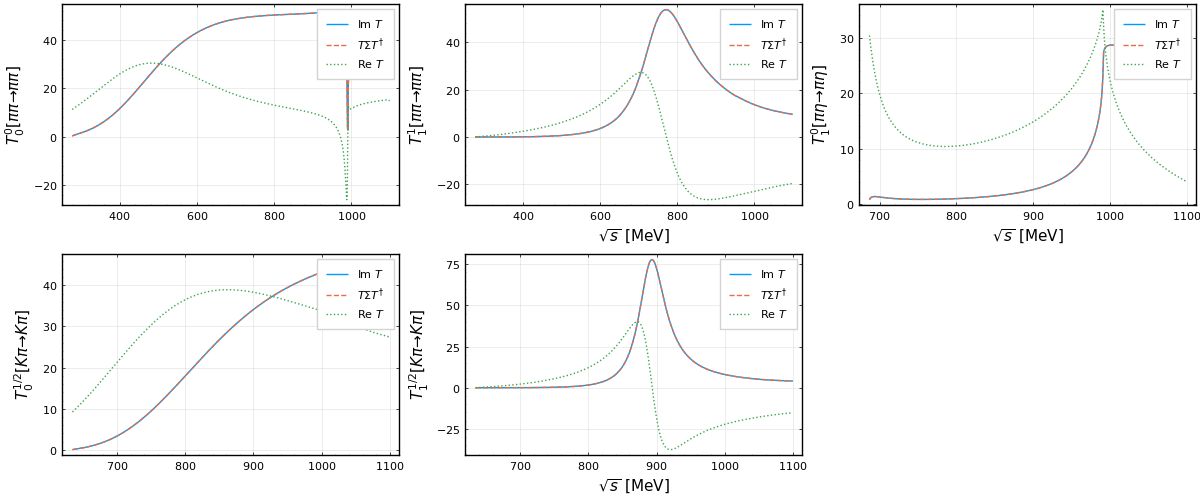

In [48]:
pyplot()
plt_unitarity(args(fit0))

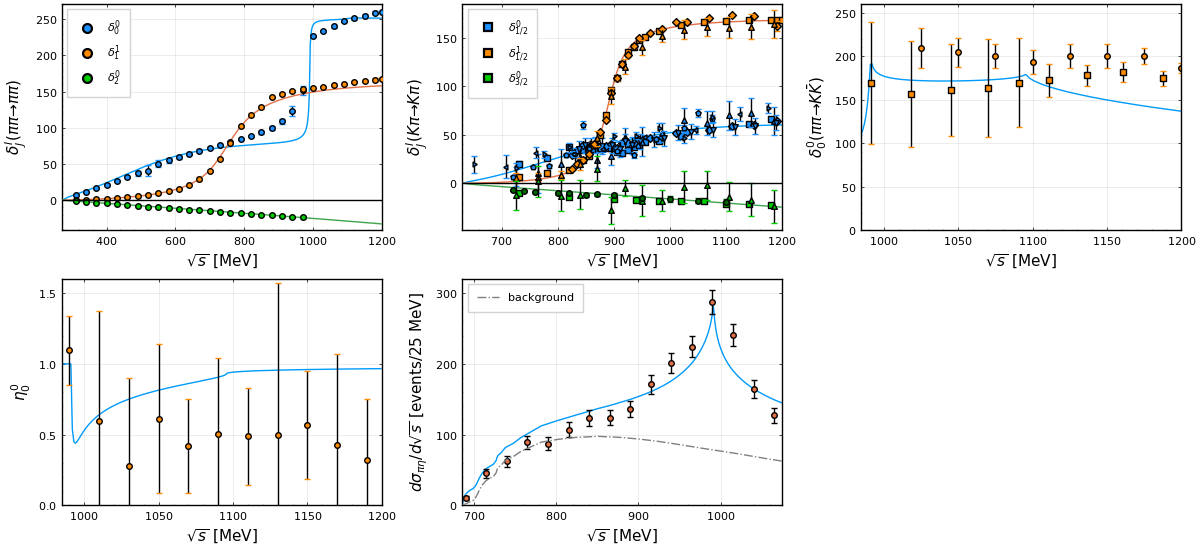

In [49]:
# pyplot()
# @time 
plt_compare(args(fit0), jump = 950)

In [50]:
view(args(fit0),1:8)

8-element view(::Vector{Float64}, 1:8) with eltype Float64:
  0.000523728001291732
  0.001076867991350742
 -0.002719569589427939
 -0.0002649536687919879
  0.0013792774720517407
  7.0e-5
 -0.0006093963454580423
  0.00090515619431664

### with increased errors following the paper by Gomez Nicola and Pelaez

In [51]:
const add_err = 0.05; 
const lec_best0 = [0.522, 1.081, -2.7, -0.279, 1.87, 0.07, -1.29, 1.70] .*1e-3;

In [52]:
# increase the data error by  `factor` times of the data value
# weight(dat::Data, factor) = Data(dat.x, dat.y, dat.err .* factor)
weight(dat::Data, factor) = Data(dat.x, dat.y, (@. dat.err + factor * abs(dat.y)) );

In [53]:
χsq_pc_00(pars) = chisq_ps(δ00_0, weight(data_ππ00, add_err), @views pars[1:8])
χsq_pc_11(pars) = chisq_ps(δ11, weight(data_ππ11, add_err), @views pars[1:8]) 
χsq_pc_20(pars) = chisq_ps(δ20, weight(data_ππ20, add_err), @views pars[1:8])
χsq_pc_η00(pars) = chisq(η00, weight(data_ππ00_eta, add_err), @views pars[1:8]);
χsq_pc_ππkk00(pars) = chisq_ps(δππkk00, weight(data_ππKK00, add_err), @views pars[1:8])

χsq_pc_half0(pars) = chisq_ps(δhalf0, weight(data_πK10, add_err), @views pars[1:8])
χsq_pc_half1(pars) = chisq_ps(δhalf1, weight(data_πK11, add_err), @views pars[1:8])
χsq_pc_3half0(pars) = chisq_ps(δ3half0, weight(data_πK30, add_err), @views pars[1:8]);

χsq_pc_πη(pars) = chisq(σπη, weight(data_πη[1:16], add_err), pars);

In [54]:
macro show_individual_pc(lec)
    summing = 0.0
    _list = ["00", "11", "20", "half0", "half1", "3half0", "ππkk00", "η00", "πη"]
    dofs = (31, 31, 23, 103, 58, 36, 17, 30, 16)
    for i in eachindex(_list)
        func = Symbol("χsq_pc_$(_list[i])")
        res = :(($func)($lec))
        @eval println("χ^2/dof in ", $(_list[i]), ":  ", $res/($(dofs[i])-8) )
        summing += eval(res)
    end
    @eval println("Total χ^2/dof:   ", $summing/(sum($dofs) -8) )
end

@show_individual_pc (macro with 1 method)

In [55]:
@show_individual_pc paras0

χ^2/dof in 00:  2.7530835115827763
χ^2/dof in 11:  0.8386024487773042
χ^2/dof in 20:  0.5014422861004179
χ^2/dof in half0:  2.4038224841020175
χ^2/dof in half1:  2.225479858461322
χ^2/dof in 3half0:  3.0104110556693113
χ^2/dof in ππkk00:  3.081683260004867
χ^2/dof in η00:  0.5543094075790158
χ^2/dof in πη:  1.9681515893769512
Total χ^2/dof:   1.6906059907213187


In [56]:
@show_individual_pc args(fit0)

χ^2/dof in 00:  3.0040346729109375
χ^2/dof in 11:  0.43511957945725244
χ^2/dof in 20:  0.10036919482579565
χ^2/dof in half0:  1.5532270429993487
χ^2/dof in half1:  1.211106495848762
χ^2/dof in 3half0:  2.509968324400893
χ^2/dof in ππkk00:  3.6530184519054054
χ^2/dof in η00:  0.5145522439230931
χ^2/dof in πη:  2.767087959639276
Total χ^2/dof:   1.262110124029755


In [57]:
χsq_pc(pars) = (χsq_pc_00(pars)  + χsq_pc_11(pars) + χsq_pc_20(pars) + χsq_pc_ππkk00(pars) + χsq_pc_η00(pars)
             + χsq_pc_half0(pars) + χsq_pc_half1(pars) + χsq_pc_3half0(pars) + χsq_pc_πη(pars)
    )
fit_pc = Minuit(χsq_pc, paras0, error=1e-6*ones(9), name = name,
     fix_L1=false, fix_L3=false, fix_L4=false, fix_L5=false, fix_L6=true, fix_L7=false, fix_L8=false
)
fit_pc.strategy = 2;

In [58]:
# @time 
migrad(fit_pc)

PyObject MigradResult(fmin=FMin(fval=406.4281098627367, edm=2.9204584659307442e-05, tolerance=0.1, nfcn=495, nfcn_total=495, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False, ngrad=0, ngrad_total=0), params=[Param(number=0, name='L1', value=0.0005460034901824906, error=1.679428846074474e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='L2', value=0.0010701879029292182, error=2.953331266518546e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='L3', value=-0.002756504154023636, error=3.23713530842978e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='L4', value=-0.000201550566175379, error=1.7901176275336528e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='L5', value=0.0011282937143766564, error=0.0005853677031154949, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='L6', value=7e-05, error=1e-06, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='L7', value=-0.0005246953543087891, error=0.00011165023944360558, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='L8', value=0.0006806608598719314, error=0.00027478649094959994, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='c', value=0.00010919303010056762, error=1.0495410499653765e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [59]:
lec_best_plus5pc = [0.546, 1.07, -2.756, -0.202, 1.1, 0.07, -0.52, 0.68, 0.109] .*1e-3;

In [60]:
@show_individual_pc args(fit_pc)

χ^2/dof in 00:  2.9400917489875757
χ^2/dof in 11:  0.7024899115422771
χ^2/dof in 20:  0.09917724789919673
χ^2/dof in half0:  1.4441309373144278
χ^2/dof in half1:  1.0665877395190995
χ^2/dof in 3half0:  2.445903488728802
χ^2/dof in ππkk00:  3.640239709458927
χ^2/dof in η00:  0.4773997351855248
χ^2/dof in πη:  2.3611247109522733
Total χ^2/dof:   1.2060181301564887


In [61]:
# @time 
hesse(fit_pc)
# @time 
hesse(fit_pc)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,L1,0.546e-3,0.018e-3,,,,,
1,L2,1.07e-3,0.03e-3,,,,,
2,L3,-2.757e-3,0.034e-3,,,,,
3,L4,-0.202e-3,0.018e-3,,,,,
4,L5,1.1e-3,0.6e-3,,,,,
5,L6,70e-6,1e-6,,,,,yes
6,L7,-0.52e-3,0.12e-3,,,,,
7,L8,0.68e-3,0.29e-3,,,,,
8,c,0.109e-3,0.010e-3,,,,,


In [62]:
# @time 
minos(fit_pc)

return Minos error 0.00765811  , -0.0015997
return Minos error -0.00913795  , 0.0113337
return Minos error 0.0102839  , -0.00602362
return Minos error 0.118464  , -0.135065
return Minos error 0.00956264  , -0.0053349
return Minos error -0.0313371  , 0.0645562
return Minos error 0.014639  , -0.00982176
return Minos error -0.0287739  , 0.0382885


PyObject MErrors([('L1', MError(name='L1', is_valid=True, lower=-1.8196778374052245e-05, upper=1.8029596332907347e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=146, min=0.0005460034901824906)), ('L2', MError(name='L2', is_valid=True, lower=-2.993088949170524e-05, upper=3.054927503059054e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=173, min=0.0010701879029292182)), ('L3', MError(name='L3', is_valid=True, lower=-3.477653804900124e-05, upper=3.4215190889738e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=172, min=-0.002756504154023636)), ('L4', MError(name='L4', is_valid=True, lower=-2.0102715192971582e-05, upper=1.5545913768755026e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=367, min=-0.000201550566175379)), ('L5', MError(name='L5', is_valid=True, lower=-0.0006149879280260324, upper=0.0006059128974763303, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=172, min=0.0011282937143766564)), ('L7', MError(name='L7', is_valid=True, lower=-0.00011222315660455258, upper=0.00012333274199041052, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=312, min=-0.0005246953543087891)), ('L8', MError(name='L8', is_valid=True, lower=-0.0002906240788132443, upper=0.0002836177454445234, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=304, min=0.0006806608598719314)), ('c', MError(name='c', is_valid=True, lower=-1.0214827204957689e-05, upper=1.092015276710739e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=203, min=0.00010919303010056762))])

In [63]:
# @time 
migrad(fit_pc)

PyObject MigradResult(fmin=FMin(fval=406.42808159382713, edm=4.807787932262071e-10, tolerance=0.1, nfcn=135, nfcn_total=2601, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False, ngrad=0, ngrad_total=0), params=[Param(number=0, name='L1', value=0.0005459878403772403, error=1.6792574732596673e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='L2', value=0.0010701301915278698, error=2.9529600251141328e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='L3', value=-0.0027564880546484126, error=3.2369794091228884e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='L4', value=-0.0002015252445138933, error=1.7889959659782688e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='L5', value=0.0011289924212696412, error=0.0005853638494751509, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='L6', value=7e-05, error=1e-06, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='L7', value=-0.0005246025556979511, error=0.00011171992293956941, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='L8', value=0.0006808512694057766, error=0.0002748124499623549, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='c', value=0.00010921283287650647, error=1.0499399466573754e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [64]:
matrix(fit_pc, corrletion=true)

,L1,L2,L3,L4,L5,L7,L8,c
L1,1.00,0.87,-0.70,0.44,-0.41,0.40,-0.49,-0.06
L2,0.87,1.00,-0.63,-0.03,-0.45,0.46,-0.58,-0.10
L3,-0.70,-0.63,1.00,-0.33,0.89,-0.74,0.86,-0.14
L4,0.44,-0.03,-0.33,1.00,-0.14,0.07,-0.06,0.11
L5,-0.41,-0.45,0.89,-0.14,1.00,-0.80,0.92,-0.19
L7,0.40,0.46,-0.74,0.07,-0.80,1.00,-0.93,0.45
L8,-0.49,-0.58,0.86,-0.06,0.92,-0.93,1.00,-0.28
c,-0.06,-0.10,-0.14,0.11,-0.19,0.45,-0.28,1.00


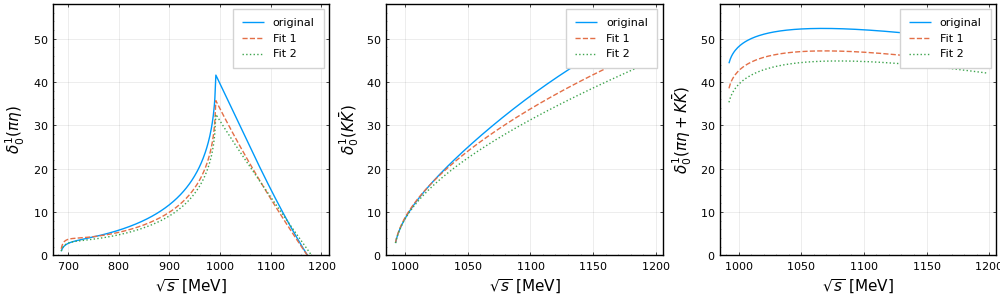

In [65]:
# @time 
let p1, p2, lec = view(args(fit0), 1:8), lec2 = view(args(fit_pc), 1:8)
    p1 = plot(mpi+meta:1:1200, x->δ10_πη_0(x,lecr0), ylab = L"\delta_0^1(\pi\eta)", label="original")
    plot!(mpi+meta:1:1200, x->δ10_πη_0(x, lec), line=:dash, label="Fit 1" )
    plot!(mpi+meta:1:1200, x->δ10_πη_0(x, lec2), line=:dot, label="Fit 2" )
    p2 = plot(2mk:1:1200, x->δ10_kk(x,lecr0), ylab = L"\delta_0^1(K\bar K)", label="original")
    plot!(2mk:1:1200, x->δ10_kk(x,lec), line=:dash, label="Fit 1")
    plot!(2mk:1:1200, x->δ10_kk(x,lec2), line=:dot, label="Fit 2")
    p3 = plot(2mk:1:1200, x->δ10_πη_0(x,lecr0)+δ10_kk(x,lecr0), ylab = L"\delta_0^1(\pi\eta+K\bar K)", label="original")
    plot!(2mk:1:1200, x->δ10_πη_0(x,lec)+δ10_kk(x,lec), line=:dash, label="Fit 1")
    plot!(2mk:1:1200, x->δ10_πη_0(x,lec2)+δ10_kk(x,lec2), line=:dot, label="Fit 2")
    plot(p1, p2, p3, layout=(1,3), size = (1000,300), xlab=L"\sqrt{s}"*" [MeV]", ylim=(0,58))
end 

The above phase shifts are different from those in the following two papers:

* [1507.04526](https://arxiv.org/abs/1507.04526): *Form factors of the isovector scalar current and the ηπ scattering phase shifts*
by M. Albaladejo, B. Moussallam
* [2002.04441](https://arxiv.org/abs/2002.04441): *The πη interaction and $a_0$ resonances in photon-photon scattering* by
Junxu Lu, B. Moussallam
<img src="./datajl/pieta_150704526.png" style="height: 250px;"/>  <img src="./datajl/pieta_200204441.png" style="height: 250px;"/> 

One reason for the difference would be that these analyses have higher $a_0$ states built in, while the UCHPT does not. 

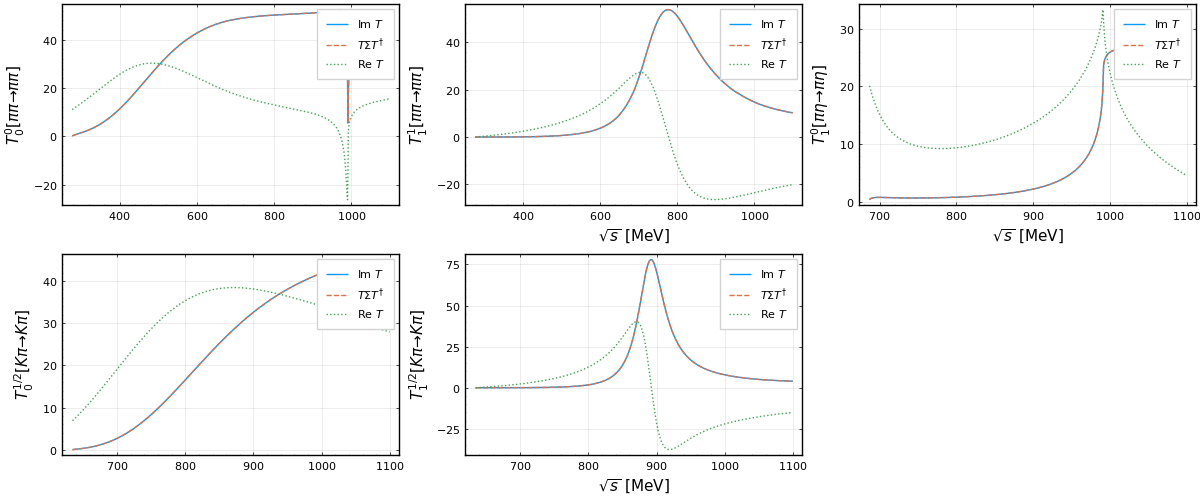

In [66]:
plt_unitarity(args(fit_pc) )

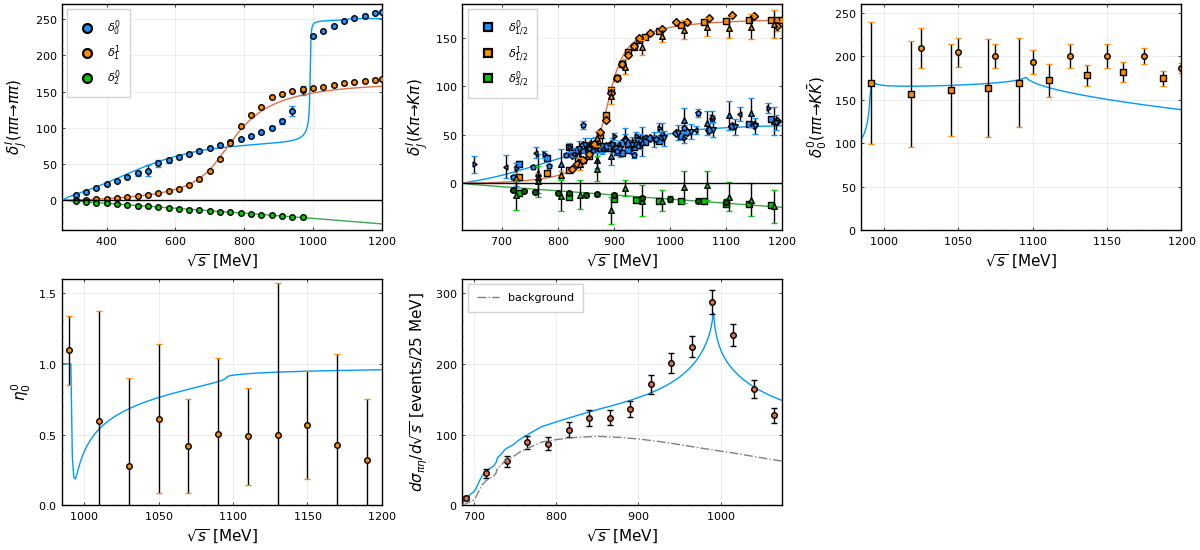

In [67]:
# @time 
plt_compare(args(fit_pc), jump = 950)

In [309]:
# ------------------------take a long time to run, not needed------------------------------------------------
# @time parasdf_plus5pc = contour_df(fit_pc, χsq_pc, npts = 10)

13831.496368 seconds (14.67 M allocations: 1.251 GiB, 0.00% gc time)


Error in MnContours: unable to find Upper y Value for x Parameter : px = 0
Error in MnContours: unable to find Upper y Value for x Parameter : px = 0
Error in MnContours: unable to find Upper y Value for x Parameter : px = 0
Error in MnContours: unable to find Upper y Value for x Parameter : px = 0
Error in MnContours: unable to find Upper y Value for x Parameter : px = 0
Error in MnContours: unable to find Upper y Value for x Parameter : px = 0
Error in MnContours: unable to find Upper y Value for x Parameter : px = 0
Error in MnContours : unable to find point on Contour : i+1 = 5
Error in MnContours : found  only i points : i = 4
Error in MnContours : unable to find point on Contour : i+1 = 8
Error in MnContours : found  only i points : i = 7
Error in MnContours : unable to find point on Contour : i+1 = 8
Error in MnContours : found  only i points : i = 7
Error in MnContours : unable to find point on Contour : i+1 = 8
Error in MnContours : found  only i points : i = 7
Error in MnCont

,χ²,L1,L2,L3,L4,L5,L6,L7,L8,c
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,406.428,0.000545988,0.00107013,-0.00275649,-0.000201525,0.00112899,7.0e-5,-0.000524602,0.000680851,0.000109213
2,407.429,0.000527802,0.00104407,-0.00273138,-0.000212328,0.0013913,7.0e-5,-0.00057199,0.000824127,0.000109563
3,407.428,0.000564029,0.00109794,-0.0027816,-0.000193161,0.000853295,7.0e-5,-0.000472335,0.000524819,0.000108841
4,407.431,0.00053003,0.00104022,-0.00273343,-0.000203499,0.00142305,7.0e-5,-0.000580101,0.000851035,0.00011007
5,407.426,0.000562257,0.0011007,-0.00277984,-0.000199535,0.000828064,7.0e-5,-0.000466244,0.000504501,0.000108476
6,407.428,0.000559166,0.00109086,-0.00279128,-0.00019471,0.000570198,7.0e-5,-0.000435421,0.000427414,0.000110811
7,407.428,0.000532697,0.00105,-0.00272229,-0.000209201,0.00166657,7.0e-5,-0.000610767,0.000925652,0.000107613
8,407.426,0.000536009,0.0010671,-0.00274286,-0.000221626,0.00125452,7.0e-5,-0.000539709,0.00072115,0.000108088
9,407.433,0.000555067,0.0010742,-0.00277039,-0.000185977,0.00100374,7.0e-5,-0.00050763,0.000635884,0.000110118


In [310]:
# CSV.write("paras_plus5pc_mncount.csv", parasdf_plus5pc)

"paras_plus5pc_mncount.csv"

In [71]:
parasdf_plus5pc = DataFrame(CSV.File("paras_plus5pc_mncount.csv"));

In [72]:
# pick out the parameter sets with χ² smaller than the best fit, suspected to given unphysical singularity at some point, changing χ² in the 00 channel abruptly
suspected = parasdf_plus5pc[parasdf_plus5pc.χ² .<406.4, :];
physical_candidates = parasdf_plus5pc[parasdf_plus5pc.χ² .>=406.4, :];

  0.588621 seconds (1.11 M allocations: 64.225 MiB, 5.50% gc time, 93.36% compilation time)


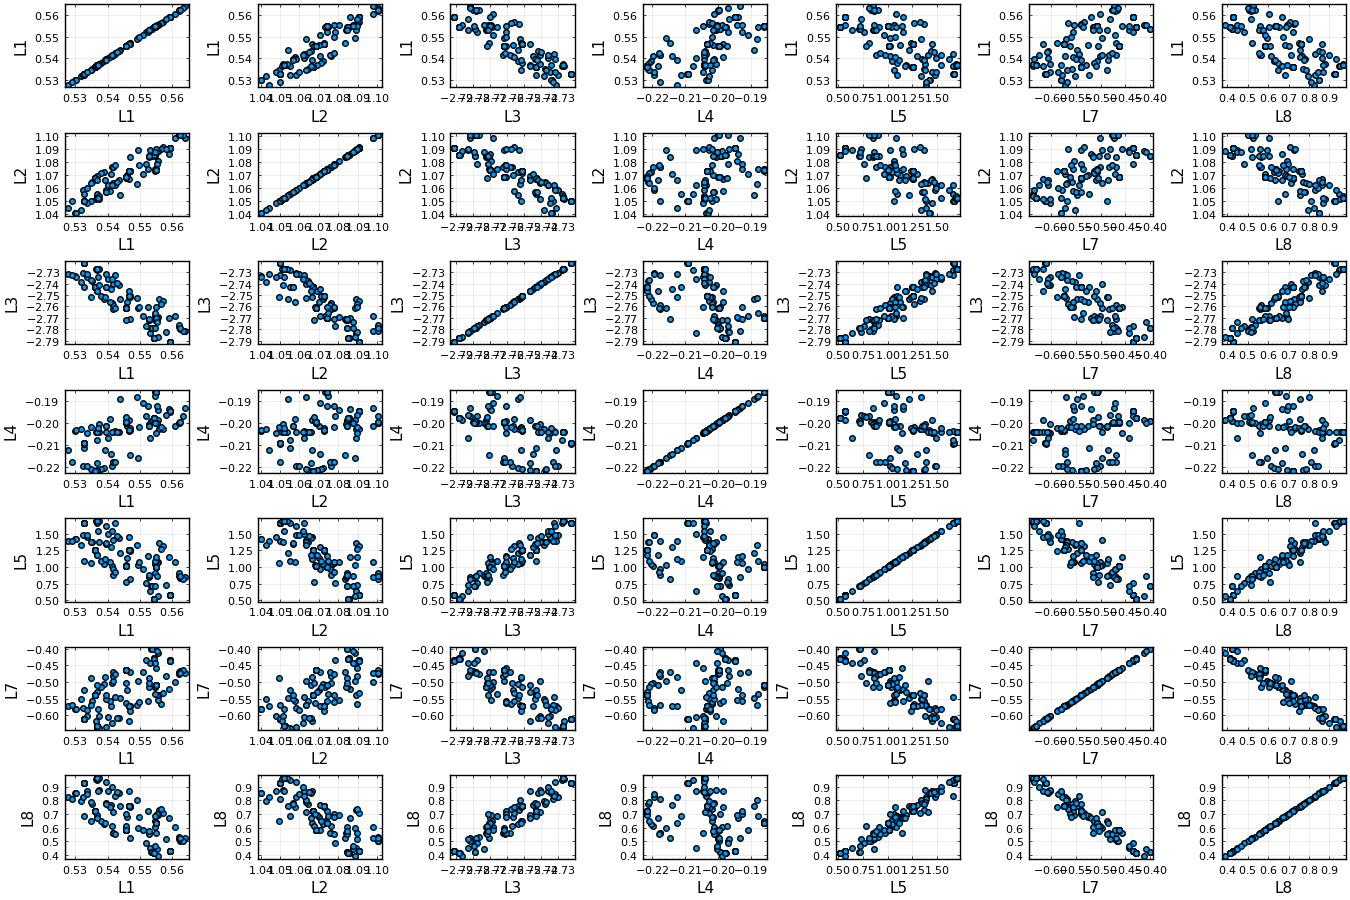

In [74]:
pyplot()
@time plt_paras(physical_candidates .* 1e3)

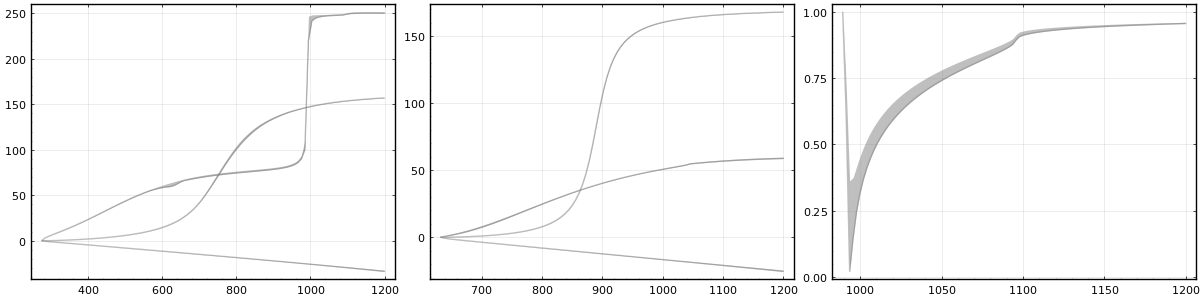

In [75]:
# it turns out that all the parameter sets in physical_candidates do not have unphysical singularities
pyplot()
let p1, p2, p3
    p1 = plt_band(physical_candidates, ππ, (x, p)->δ00(x,p, jump=930))
    plt_band!(physical_candidates, ππ, δ11)
    plt_band!(physical_candidates, ππ, δ20)
    p2 = plt_band(physical_candidates, Kπ, δhalf0)
    plt_band!(physical_candidates, Kπ, δhalf1)
    plt_band!(physical_candidates, Kπ, δ3half0)
    p3 = plt_band(physical_candidates, KK, η00) #πη, σπη)

    plot(p1, p2, p3, layout= (1, 3), size=(1200,300))
end

In [76]:
CSV.write("paras_plus5pc_physical.csv", physical_candidates)

"paras_plus5pc_physical.csv"

In [68]:
function plt_compare2(lec, lec_pc, bands::DataFrame=physical_candidates; jump = 930)
    _lec = Ref(lec); _lec0 = Ref(paras0); _paras = bands; _lecpc = Ref(lec_pc);
    wv = 270:1.0:1200
    p1 = plot(wv, δ00.(wv, _lec; jump = jump), line=:dot, label="", xlim = (wv[1], wv[end]),legend=:topleft)
    plt_band!(_paras, ππ, (x, p)->δ00(x,p, jump=920), color=:dodgerblue)
    plot!(wv, δ00.(wv, _lecpc; jump = jump), color=:dodgerblue, label="" )
    plot!(wv, δ11.(wv, _lec), line=:dot, color=:darkorange, label="" )
    plot!(wv, δ11.(wv, _lecpc), color=:darkorange, label="" )
    plt_band!(_paras, ππ, δ11, color=:darkorange)
    plot!(wv, δ20.(wv, _lec), label="", color=:green3, line=:dot )
    plot!(wv, δ20.(wv, _lecpc), color=:green3, label="" )
    plt_band!(_paras, ππ, δ20, color=:green3)
    plot!(wv, δ00.(wv, _lec0; jump = jump), label="", line=:dash, color=:dodgerblue  )
    plot!(wv, δ11.(wv, _lec0), label="", line=:dash, color=:darkorange )
    plot!(wv, δ20.(wv, _lec0), label="", line=:dash, color=:green3)
    @plt_data! data_ππ00 label = L"\delta_{0}^0" marker = (:circle, :dodgerblue)
    @plt_data! data_ππ11 label = L"\delta_{1}^1" marker = (:circle, :darkorange)
    @plt_data! data_ππ20 label = L"\delta_{0}^2" marker = (:circle, :green3) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{J}^I (\pi\pi\to \pi\pi)"
    hline!([0], color = :black, label=:none)    
    
    xv = 630:1.0:1200
    p2 = plot(xv, δhalf0.(xv, _lec), line=:dot, label="", xlim = (xv[1], xv[end]),legend=:topleft)
    plot!(xv, δhalf0.(xv, _lecpc), color=:dodgerblue, label="" )
    plt_band!(_paras, Kπ, δhalf0, color=:dodgerblue)
    plot!(xv, δhalf1.(xv, _lec), line=:dot, color=:darkorange, label="" )
    plot!(xv, δhalf1.(xv, _lecpc), color=:darkorange, label="" )
    plt_band!(_paras, Kπ, δhalf1, color=:darkorange)
    plot!(xv, δ3half0.(xv, _lec), line=:dot, color=:green3, label="" )
    plot!(xv, δ3half0.(xv, _lecpc), color=:green3, label="" )
    plt_band!(_paras, Kπ, δ3half0, color=:green3)
    plot!(wv, δhalf0.(wv, _lec0), label="", line=:dash, color=:dodgerblue  )
    plot!(wv, δhalf1.(wv, _lec0), label="", line=:dash, color=:darkorange )
    plot!(wv, δ3half0.(wv, _lec0), label="", line=:dash, color=:green3)
    plot!(wv, δhalf0.(wv, _lec0), label="", line=:dash, color=:dodgerblue  )
    plot!(wv, δhalf1.(wv, _lec0), label="", line=:dash, color=:darkorange )
    plot!(wv, δ3half0.(wv, _lec0), label="", line=:dash, color=:green3)
    @plt_data! Data(data_πK10_Estabrooks_df)[1:19] label = L"\delta^{1/2}_0" marker = (:rect, :dodgerblue)
    @plt_data! Data(data_πK10_Aston_df)[1:21] label = "" marker = (:diamond, :dodgerblue)
    @plt_data! Data(data_πK10_Mercer_df)[1:14] label = "" marker = (:utriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Bingham_df)[1:19] label = "" marker = (:dtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Baker_df) label = "" marker = (:pentagon, :dodgerblue)
    @plt_data! Data(data_πK10_BES_df) label = "" marker = (:rtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_BaBar_df) label = "" marker = (:ltriangle, :dodgerblue)
    
    @plt_data! Data(data_πK11_Estabrooks_df)[1:23] label = L"\delta^{1/2}_1" marker = (:rect, :darkorange)
    @plt_data! Data(data_πK11_Aston_df)[1:21] label = "" marker = (:diamond, :darkorange)
    @plt_data! Data(data_πK11_Mercer_df)[1:14] label = "" marker = (:utriangle, :darkorange)
 
    @plt_data! Data(data_πK30_Estabrooks_df)[1:10] label = L"\delta^{3/2}_0" marker = (:rect, :green3)
    @plt_data! Data(data_πK30_Mercer_df)[1:14] label="" marker = (:utriangle, :green3)
    @plt_data! Data(data_πK30_Lingin_df) label="" marker=(:circle, :green3) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{J}^I (K\pi\to K \pi)"
    hline!([0], color = :black, label=:none)   
    
    wv2 = 985:1.0:1200
    p3 = plot(wv2, δππkk00.(wv2, _lec), line=:dot, label = "", xlim = (wv2[1], wv2[end]), ylim=(0,260) )
    plot!(wv2, δππkk00.(wv2, _lecpc), label="", color=:dodgerblue)
    plt_band!(_paras, KK, δππkk00, color=:dodgerblue)
    plot!(wv2, δππkk00.(wv2, _lec0), label="", line=:dash, color=:dodgerblue)
    @plt_data! Data(data_ππkk00_Cohen_df) label = "" marker = :dodgerblue
    @plt_data! Data(data_ππkk00_Martin_df)[1:9] label="" marker=(:rect,:dodgerblue) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{0}^0 (\pi\pi\to K \bar K)"
       
    p4 = plot(wv2, η00.(wv2, _lec), line=:dot, legend = :none, xlim = (wv2[1], wv2[end]), ylim=(0, 1.6))
    plot!(wv2, η00.(wv2, _lecpc), color=:dodgerblue)
    plt_band!(_paras, KK, η00, color=:dodgerblue)
    plot!(wv2, η00.(wv2, _lec0), label="", line=:dash, color=:dodgerblue)
    @plt_data! data_ππ00_eta marker = :dodgerblue xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\eta_{0}^0" # label = L"\eta_{0}^0"
    
    wv3 = (mpi+meta+0.000001):1.0:1075
    p5 = plot(wv3, σπη.(wv3, _lec), line=:dot, label = "", xlim = (wv3[1], wv3[end]) ,legend=:topleft)
    plot!(wv3, σπη.(wv3, _lecpc), label="",  color=:dodgerblue)
    plt_band!(_paras, πη, σπη, color=:dodgerblue)
    plot!(wv3, σπη.(wv3, _lec0), label="", line=:dash, color=:dodgerblue)
    @plt_data! data_πη[1:16] label = "" marker = :dodgerblue
    plot!(wv3, data_πη_WA76_bg.(wv3), line=(:dashdot, :gray), label="background" )
    plot!(xlab=L"\sqrt{s}"*" [MeV]", ylab = L"d\sigma_{\pi\eta}/d\sqrt{s}"*" [events/25 MeV]", ylim=(0, 320))
    
    plot(p1, p2, p3, p4, p5, plot(legend=false,grid=false,foreground_color_subplot=:white), layout =(3,2),#@layout([a b; c d; e _]), 
        size=(700,700), legendfontsize = 8, guidefont = 9)
end

plt_compare2 (generic function with 2 methods)

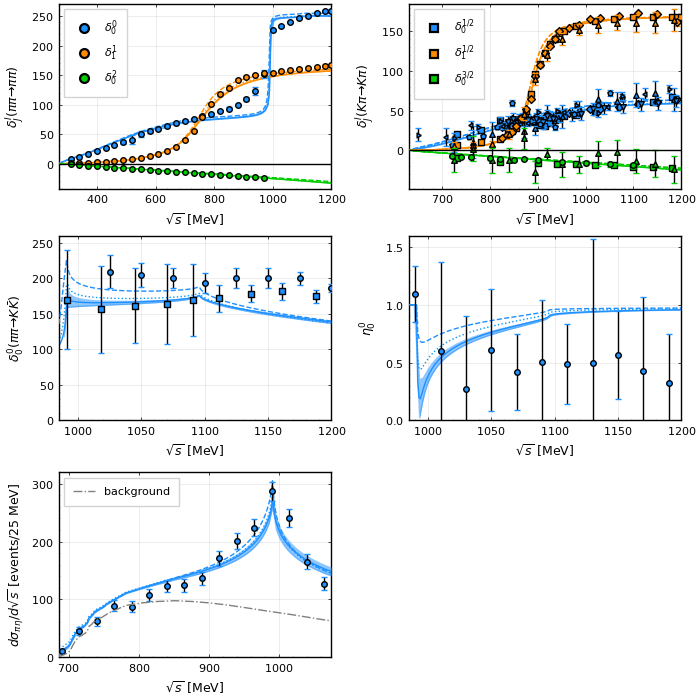

In [73]:
# @time 
plt_compare2(args(fit0), args(fit_pc), physical_candidates)
# savefig("iam_bestfit.pdf") #, bbox_inches="tight", pad_inches=0

In [74]:
# expars = map(extrema, eachcol(physical_candidates))
let _pars = map(extrema, eachcol(physical_candidates))
    [_pars[i+1] .- args(fit_pc)[i] for i in 1:9 ]
end

9-element Vector{Tuple{Float64, Float64}}:
 (-1.8185482281634106e-5, 1.8040998100469878e-5)
 (-2.9913425173091514e-5, 3.056659422566552e-5)
 (-3.47898105609876e-5, 3.420200450395157e-5)
 (-2.0100575366909526e-5, 1.5548097647793572e-5)
 (-0.0006149653113047307, 0.0005700748763814156)
 (0.0, 0.0)
 (-0.00011223770802891832, 0.00012322753296278985)
 (-0.0002906109502617072, 0.00028363166552969083)
 (-1.0217666132139345e-5, 1.0917339947368653e-5)

In [75]:
args(fit_pc)

9-element Vector{Float64}:
  0.0005459878403772403
  0.0010701301915278698
 -0.0027564880546484126
 -0.0002015252445138933
  0.0011289924212696412
  7.0e-5
 -0.0005246025556979511
  0.0006808512694057766
  0.00010921283287650647

### with increased errors except for those from DR analysis

In [80]:
add_moreerr = 0.1;

In [81]:
χsq_pc_00(pars) = chisq_ps(δ00_0, data_ππ00, @views pars[1:8])
χsq_pc_11(pars) = chisq_ps(δ11, data_ππ11, @views pars[1:8]) 
χsq_pc_20(pars) = chisq_ps(δ20, data_ππ20, @views pars[1:8])
χsq_pc_η00(pars) = chisq(η00, weight(data_ππ00_eta, add_moreerr), @views pars[1:8]);
χsq_pc_ππkk00(pars) = chisq_ps(δππkk00, weight(data_ππKK00, add_moreerr), @views pars[1:8])

χsq_pc_half0(pars) = chisq_ps(δhalf0, weight(data_πK10, add_moreerr), @views pars[1:8])
χsq_pc_half1(pars) = chisq_ps(δhalf1, weight(data_πK11, add_moreerr), @views pars[1:8])
χsq_pc_3half0(pars) = chisq_ps(δ3half0, weight(data_πK30, add_moreerr), @views pars[1:8]);

χsq_pc_πη(pars) = chisq(σπη, weight(data_πη[1:16], add_err), pars);

In [82]:
@show_individual_pc paras0

χ^2/dof in 00:  32.64718367985285
χ^2/dof in 11:  21.029179706279844
χ^2/dof in 20:  2.2726356060619497
χ^2/dof in half0:  1.2438908357544125
χ^2/dof in half1:  0.9118921086497371
χ^2/dof in 3half0:  1.629749141929082
χ^2/dof in ππkk00:  1.3950087149022723
χ^2/dof in η00:  0.48513286888513574
χ^2/dof in πη:  1.9681515893769486
Total χ^2/dof:   4.501532098040833


In [83]:
@show_individual_pc lec_best_plus5pc

χ^2/dof in 00:  30.168898624605216
χ^2/dof in 11:  27.374995111575785
χ^2/dof in 20:  0.5008363944909572
χ^2/dof in half0:  0.7639396917978732
χ^2/dof in half1:  0.5081918674249181
χ^2/dof in 3half0:  1.3554117661950722
χ^2/dof in ππkk00:  1.6421346531197831
χ^2/dof in η00:  0.41775979522950274
χ^2/dof in πη:  2.3431897534886907
Total χ^2/dof:   4.479741664083294


In [84]:
χsq_pc(pars) = (χsq_pc_00(pars)  + χsq_pc_11(pars) + χsq_pc_20(pars) + χsq_pc_ππkk00(pars) + χsq_pc_η00(pars)
               + χsq_pc_πη(pars)
             + χsq_pc_half0(pars) + χsq_pc_half1(pars) + χsq_pc_3half0(pars)
    )
fit_pc = Minuit(χsq_pc, paras0, error=1e-6*ones(9), name = name,
     fix_L1=false, fix_L3=false, fix_L4=false, fix_L5=false, fix_L6=true, fix_L7=false, fix_L8=false
)
fit_pc.strategy = 2;

In [85]:
@time migrad(fit_pc)

 17.224099 seconds (26.39 k allocations: 1.929 MiB, 0.08% compilation time)


PyObject MigradResult(fmin=FMin(fval=1086.6172455847716, edm=0.00014418427329962745, tolerance=0.1, nfcn=325, nfcn_total=325, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False, ngrad=0, ngrad_total=0), params=[Param(number=0, name='L1', value=0.000649751226220669, error=1.1360056286877474e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='L2', value=0.001302415907927884, error=1.7312510878904142e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='L3', value=-0.0029954495603476718, error=2.201479697814944e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='L4', value=-0.00025389573159550604, error=1.4993555945703251e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='L5', value=-0.001509788616162918, error=0.0003174035671563685, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='L6', value=7e-05, error=1e-06, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='L7', value=-7.535851681017867e-05, error=5.9335101987155415e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='L8', value=-0.0006211381794725103, error=0.0001571992899629918, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='c', value=9.915869692504028e-05, error=8.754404022072191e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [86]:
@show_individual_pc args(fit_pc)

χ^2/dof in 00:  23.932586257276288
χ^2/dof in 11:  8.418109250119304
χ^2/dof in 20:  7.08012734270048
χ^2/dof in half0:  0.8160299322930953
χ^2/dof in half1:  1.3495326403283727
χ^2/dof in 3half0:  1.9109775699652303
χ^2/dof in ππkk00:  1.0901745559481841
χ^2/dof in η00:  0.4256672446668905
χ^2/dof in πη:  2.3332801055839294
Total χ^2/dof:   3.2243835180557014


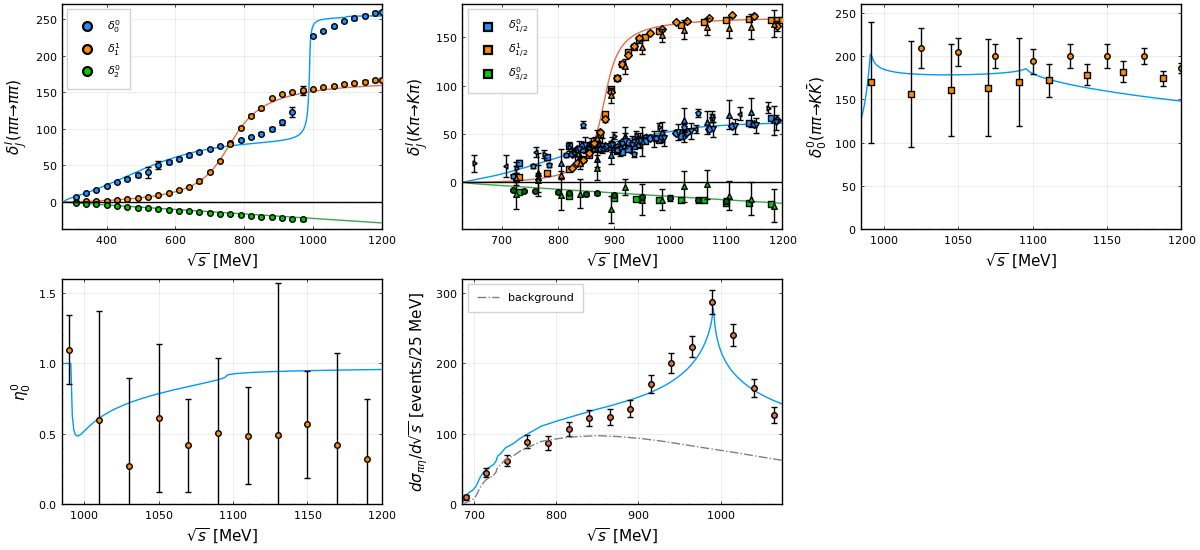

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [87]:
plt_compare(args(fit_pc), jump = 850)

# Getting Properties from IAM

## $J=0$(*the Tmatrix cannot be simply replaced by a propagator of resonance($\kappa$)*)

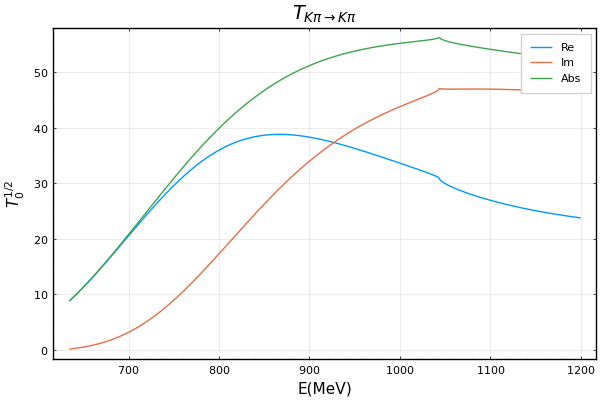

In [88]:
let wv=(Kπ.m1+Kπ.m2):1.0:1200
    tmatrix_Kπ(w;pars=args(fit_pc)[1:8])=Stiam_strange_10(w,pars)[1,1]
    plot(title=L"$T_{K\pi\rightarrow K\pi}$",xlabel="E(MeV)",ylabel=L"T_{0}^{1/2}")
    plot!(wv,w->real(tmatrix_Kπ(w)),label="Re")
    plot!(wv,w->imag(tmatrix_Kπ(w)),label="Im")
    plot!(wv,w->abs(tmatrix_Kπ(w)),label="Abs")
end

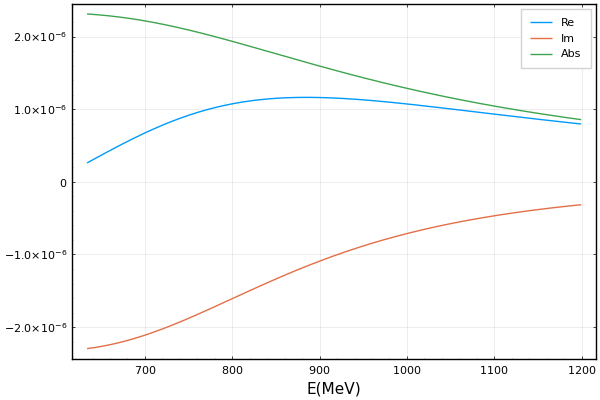

In [89]:
#https://arxiv.org/pdf/hep-ph/0310293.pdf
let mκ=594,Γκ=724,wv=(Kπ.m1+Kπ.m2):1.0:1200
    prop(w)=1/(w^2-mκ^2+im*mκ*Γκ)
    plot(wv,w->real(prop(w)),xlabel="E(MeV)",label="Re")
    plot!(wv,w->imag(prop(w)),label="Im")
    plot!(wv,w->abs(prop(w)),label="Abs")
end

## $J=1$(*The T matrix can be replaced by $K^*(892)$ very well*)

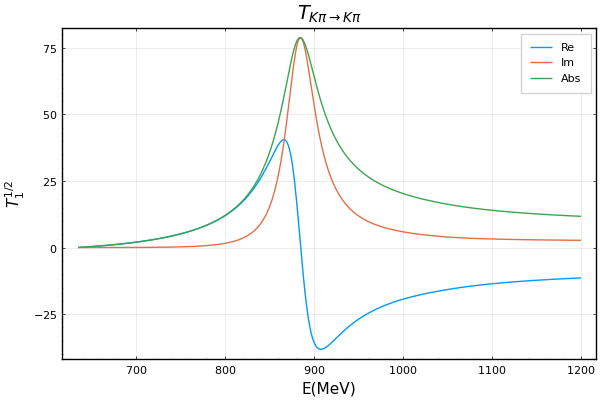

In [90]:
let wv=(Kπ.m1+Kπ.m2):1.0:1200
    tmatrix_Kπ(w;pars=args(fit_pc)[1:8])=Stiam_strange_11(w,pars)[1,1]
    plot(title=L"$T_{K\pi\rightarrow K\pi}$",xlabel="E(MeV)",ylabel=L"T_{1}^{1/2}")
    plot!(wv,w->real(tmatrix_Kπ(w)),label="Re")
    plot!(wv,w->imag(tmatrix_Kπ(w)),label="Im")
    plot!(wv,w->abs(tmatrix_Kπ(w)),label="Abs")
end

for $K^0\pi^+\rightarrow K^{*+}\rightarrow K^0\pi^+$, the T matrix(only VPP vertex@LO) can derived as:
\begin{align*}
T_{K^0\pi^+\rightarrow K^0\pi^+}(s,t,u)&=-g_{VPP}^2*\frac{t-u+\frac{(m_1^2-m_2^2)(m_3^2-m_4^2)}{m_{K^*}^2}}{s-m_{K^*}^2+I*m_{K^*}\Gamma_{K^*}}\\
&=-g_{VPP}^2*\frac{s+2*(m_1^2+m_3^2-2E_1^0E_3^0+2|\vec{p_1}||\vec{p_3}|x)-m_1^2-m_2^2-m_3^2-m_4^2+\frac{(m_1^2-m_2^2)(m_3^2-m_4^2)}{m_{K^*}^2}}{s-m_{K^*}^2+I*m_{K^*}\Gamma_{K^*}}
\end{align*}
The T matrix of $K\pi\rightarrow K^{*}\rightarrow K\pi$ is $T_{K\pi\rightarrow K\pi}(s,t,u)=\frac{3}{2}T_{K^0\pi^+\rightarrow K^0\pi^+}(s,t,u)$

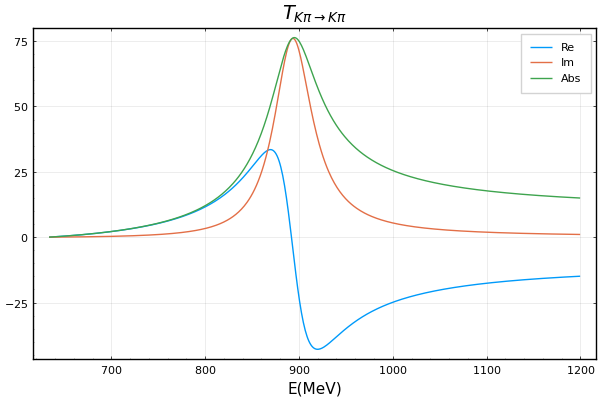

In [91]:
let mkstar=892,Γkstar=50,wv=(Kπ.m1+Kπ.m2):1.0:1200,gvpp=4.52
    m1,m2,m3,m4=mk,mpi,mk,mpi
    energy(w,m1,m2)=(w^2+m1^2-m2^2)/(2*w)
    momentum(w,m1,m2)=qon(w^2,m1,m2)
    
    prop(w,x)=-((w^2+2*(m1^2+m3^2-2*energy(w,m1,m2)*energy(w,m3,m4)+2*momentum(w,m1,m2)*momentum(w,m3,m4)*x)
        -m1^2-m2^2-m3^2-m4^2+(m1^2-m2^2)^2/mkstar^2)/(w^2-mkstar^2+im*mkstar*Γkstar))*gvpp^2
    prop(w)=pwave(x->prop(w,x))*3/2 #project to P-wave
    
    plot(wv,w->real(prop(w)),title=L"$T_{K\pi\rightarrow K\pi}$",xlabel="E(MeV)",label="Re")
    plot!(wv,w->imag(prop(w)),label="Im")
    plot!(wv,w->abs(prop(w)),label="Abs")
end

## save to data

In [92]:
let wv=(Kπ.m1+Kπ.m2+1.0):1.0:1400
    tmatrix_Kπ(w;pars=args(fit_pc)[1:8])=Stiam_strange_10(w,pars)[1,1]
    tv=tmatrix_Kπ.(wv)
    df=DataFrame(W=wv,Re=real.(tv),Im=imag.(tv))
    CSV.write("./data/data_kappa.csv",df)
end

"./data/data_kappa.csv"

In [93]:
mpi+mk

633.6844866666667